# core

> Contains the main flow

In [ ]:
#| default_exp core

In [ ]:
# Set up autoreload
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# from collections import namedtuple, defaultdict
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy
import time
import math
from pprint import pprint
## !pip install -U "ray"
import ray
import json

import AIShiftScheduler_KE5.loader as ldr
# from AIShiftScheduler_KE5.config import *
import AIShiftScheduler_KE5.config as cf
# from AIShiftScheduler_KE5.visualization import *
import AIShiftScheduler_KE5.visualization as vis
# from AIShiftScheduler_KE5.model import *
import AIShiftScheduler_KE5.model as mod
# from AIShiftScheduler_KE5.policy import *
import AIShiftScheduler_KE5.policy as pol
import AIShiftScheduler_KE5.inferencer as inf
from io import StringIO
import AIShiftScheduler_KE5.trainer as trn
import AIShiftScheduler_KE5.evaluator as evl


len(RESOURCE_TYPES)=3
['Manager', 'AssistMngr', 'RetailAssoc']

len(TYPES)=13
['Manager', 'AssistMngr', 'AssistMngr', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc']
len(aNAMES)=13
['Manager_Matt', 'AssistMngr_Mike', 'AssistMngr_Tanner', 'RetailAssoc_Jake', 'RetailAssoc_James', 'RetailAssoc_Jane', 'RetailAssoc_John', 'RetailAssoc_Jim', 'RetailAssoc_Jenny', 'RetailAssoc_Jeremy', 'RetailAssoc_Judy', 'RetailAssoc_Julie', 'RetailAssoc_Jeffrey']

len(bNAMES)=3
['Manager', 'AssistMngr', 'RetailAssoc']

len(abNAMES)=13
['Manager_Matt___Manager', 'AssistMngr_Mike___AssistMngr', 'AssistMngr_Tanner___AssistMngr', 'RetailAssoc_Jake___RetailAssoc', 'RetailAssoc_James___RetailAssoc', 'RetailAssoc_Jane___RetailAssoc', 'RetailAssoc_John___RetailAssoc', 'RetailAssoc_Jim___RetailAssoc', 'RetailAssoc_Jenny___RetailAssoc', 'RetailAssoc_Jeremy___RetailAssoc', 'RetailAssoc_Judy___RetailAssoc', 'RetailAsso

In [ ]:
!which python

/Users/kobus/AIShiftScheduler_KE5/.venv/bin/python


In [ ]:
!python --version

Python 3.10.0


In [ ]:
np.__version__, pd.__version__, mpl.__version__, ray.__version__, json.__version__

('1.24.4', '2.0.3', '3.7.4', '2.8.1', '2.0.9')

In [ ]:
# !pip freeze | grep pandas
# !pip freeze|grep openpyxl
# !pip freeze

In [ ]:
# !pip install -U ray==2.8.1
# !pip install openpyxl

In [ ]:
#| export
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
# #| export
# SICK_PROBS = load_sick_probs(f'{base_dir}/{file_name}')
# MERIT_PROBS = load_merit_probs(f'{base_dir}/{file_name}')
# EXOG_INFO = load_exog_info(f'{base_dir}/{file_name}')

In [ ]:
# check some config

In [ ]:
cf.SICK_PROBS.head()

,ResourceId,January,February,March,April,May,June,July,August,September,October,November,December
0,1,0.0300,0.0300,0.0100,0.0200,0.0200,0.0900,0.0200,0.0100,0.0100,0.0000,0.0000,0.0300
1,2,0.1000,0.0300,0.1000,0.0800,0.0100,0.0600,0.0600,0.0900,0.0700,0.0300,0.0200,0.1000
2,3,0.1300,0.0100,0.0300,0.0300,0.0300,0.0200,0.0200,0.0900,0.0000,0.0200,0.0300,0.0500
3,4,0.0900,0.0800,0.0100,0.0200,0.0700,0.0800,0.0300,0.0400,0.0700,0.0200,0.0300,0.0900
4,5,0.0200,0.0200,0.0900,0.0900,0.0900,0.0400,0.0300,0.0500,0.0200,0.1000,0.1100,0.0700


In [ ]:
cf.MERIT_PROBS.head()

,ResourceId,MeritProb,DemeritProb
0,1,0.0100,0.0400
1,2,0.2000,0.0900
2,3,0.3000,0.0300
3,4,0.2000,0.1500
4,5,0.0500,0.0200


In [ ]:
cf.EXOG_INFO.head()

,Date,DOW,DOW_name,QOD,HOD,BOD,A_0,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9,A_10,A_11,A_12,D_0,D_1,D_2,M_0,M_1,M_2,M_3,M_4,M_5,M_6,M_7,M_8,M_9,M_10,M_11,M_12,busyness,volume,revenue
0,2023-12-04 00:00:00,0,2023-12-04 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0000
1,2023-12-04 00:15:00,0,2023-12-04 00:15:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,-1,1,0,0,0,NaN,NaN
2,2023-12-04 00:30:00,0,2023-12-04 00:30:00,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,1,-1,0,0,-1,-1,0,NaN,NaN
3,2023-12-04 00:45:00,0,2023-12-04 00:45:00,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1,0,0,0,0,-1,0,0,-1,-1,0,NaN,NaN
4,2023-12-04 01:00:00,0,2023-12-04 01:00:00,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,-1,-1,0,0,0.0000


In [ ]:
cf.MODES

['TRAIN', 'EVALU']

In [ ]:
cf.MAX_RESOURCE_TYPES

3

In [ ]:
cf.MAX_RESOURCE_IDS

13

In [ ]:
cf.aNAMES

['Manager_Matt',
 'AssistMngr_Mike',
 'AssistMngr_Tanner',
 'RetailAssoc_Jake',
 'RetailAssoc_James',
 'RetailAssoc_Jane',
 'RetailAssoc_John',
 'RetailAssoc_Jim',
 'RetailAssoc_Jenny',
 'RetailAssoc_Jeremy',
 'RetailAssoc_Judy',
 'RetailAssoc_Julie',
 'RetailAssoc_Jeffrey']

In [ ]:
cf.bNAMES

['Manager', 'AssistMngr', 'RetailAssoc']

In [ ]:
cf.abNAMES

['Manager_Matt___Manager',
 'AssistMngr_Mike___AssistMngr',
 'AssistMngr_Tanner___AssistMngr',
 'RetailAssoc_Jake___RetailAssoc',
 'RetailAssoc_James___RetailAssoc',
 'RetailAssoc_Jane___RetailAssoc',
 'RetailAssoc_John___RetailAssoc',
 'RetailAssoc_Jim___RetailAssoc',
 'RetailAssoc_Jenny___RetailAssoc',
 'RetailAssoc_Jeremy___RetailAssoc',
 'RetailAssoc_Judy___RetailAssoc',
 'RetailAssoc_Julie___RetailAssoc',
 'RetailAssoc_Jeffrey___RetailAssoc']

#### 4.3.6 Implementation of the System Under Steer (SUS) Model
> See `model` module

### 4.6 Policy Evaluation

#### 4.6.1 Training/Tuning

In [ ]:
## hide
V = vis.Visualization()
Labels = V.setup_plot_labels()

In [ ]:
# # hide
# # QUICK STEP
# def print_S_t():
#   print(f'M.S_t["R_t"]=\n{M.S_t["R_t"]}')
#   print(f'M.S_t["D_t"]=\n{M.S_t["D_t"]}')

# def print_x_t():
#   # print(f'x_t.x_t= {x_t.x_t}')
#   print(f'M.x_t["xAlloc_t"]=\n{M.x_t["xAlloc_t"]}')

# record = []
# l = 1
# M = Model()
# P = Policy(M)
# ## DEM = DemandSimulator(seed=SEED_TRAIN); print(f'{DEM.simulate()=}')
# ## MER = MeritSimulator(seed=SEED_TRAIN); print(f'{MER.simulate()=}')

# theta_test = P.build_theta({
#   'thCumSlots': .1,
#   'thSickProb': .3,
#   'thCumMerits': .2,
#   'thContSlots': 1 - (.6),
#   'thSelect': 'random'
# })
# record_l = [cf.piNAMES[0], theta_test, l]; print(f'{record_l=}')
# print_S_t()
# print_x_t()

In [ ]:
# ## hide
# # T = 7*24
# # T = 2*24
# T = 2
# # T = 1*SLOTS_PER_DAY
# # T = 2*SLOTS_PER_DAY
# dt = pd.to_datetime(cf.START_DATE_TIME)
# dt_delta = pd.Timedelta(cf.DATE_TIME_DELTA)
# for t in range(T):
#   print(f'\n################# t={t}, dt={dt} #################')
#   # getattr(P, 'X__AllocBelow')(t, M.S_t, M.x_t, theta_test); #print(f'{x_t=}')
#   getattr(P, 'X__Alloc')(t, dt, M.S_t, M.x_t, theta_test); #print(f'{x_t=}')
#   print_S_t()
#   print_x_t()

#   # record_t = M.step(t, theta_test)
#   record_t = M.step(t, dt, theta_test)
#   print(f'\nAFTER STEP:')
#   record.append(record_l + record_t); #print(f'{record=}')
#   dt = dt + dt_delta
#   # print_S_t()
#   # print(f'{M.Ccum=}')

In [ ]:
# ## hide
# df_test_n_t = pd.DataFrame.from_records(record, columns=Labels)
# df_test_n_t.tail()

In [ ]:
# ## hide
# V.plot_records(
#   df=df_test_n_t,
#   df_non=None,
#   pars=defaultdict(str, {
#     # 'thetaAdj1': {a1n: theta_test.thAdj1[a1n] for a1n in a1NAMES},
#     # 'thetaAdj3': {a1n: theta_test.thAdj3[a1n] for a1n in a1NAMES},
#     # 'suptitle': f'TRAINING OF X__AdjBelow POLICY'+'\n'+f'(first {first_n_t} records)'+'\n'+ \
#     # f'L = {L}, T = {T}, '+ \
#     # r'$\theta^*=$'+f'{P.round_theta(best_theta_AdjBelow)}',
#     'T': T
#   }),
# )

In [ ]:
# ///
# def do_train(): !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# def do_train(L, T):
#   # global DEM, MER, \
#   global Df_first_n_t, Df_last_n_t, ThetasCumSlots, \
#   ThetasSickProb, ThetasCumMerits, ThetasContSlots, ThetasSelect, \
#   ThetaStar_expCbarcum_Alloc, ThetaStar_expCtilcum_Alloc, \
#   Cbarcum_Alloc, Ctilcum_Alloc, Best_theta_Alloc, Worst_theta_Alloc, \
#   Best_Cbarcum_Alloc, Worst_Cbarcum_Alloc, \
#   Best_Ctilcum_Alloc, Worst_Ctilcum_Alloc, \
#   Record_Alloc, First_n_t, Last_n_t, \
#   Thetas # Thetas #for parallelization

#   M = Model()
#   P = Policy(M)
#   ## DEM = DemandSimulator(seed=SEED_TRAIN)
#   ## MER = MeritSimulator(seed=SEED_TRAIN)

#   ThetasCumSlots = np.arange(cf.TH_CumSlots_SPEC[0], cf.TH_CumSlots_SPEC[1], cf.TH_CumSlots_SPEC[2])
#   ## ThetasCumSlots = TH_CumSlots_SPEC

#   ## ThetasSickProb = np.arange(TH_SickProb_SPEC[0], TH_SickProb_SPEC[1], TH_SickProb_SPEC[2])
#   ThetasSickProb = cf.TH_SickProb_SPEC

#   ThetasCumMerits = np.arange(cf.TH_CumMerits_SPEC[0], cf.TH_CumMerits_SPEC[1], cf.TH_CumMerits_SPEC[2])
#   ## ThetasCumMerits = TH_CumMerits_SPEC

#   ## BALANCE/REMAINING 
#   ## ThetasContSlots = np.arange(TH_ContSlots_SPEC[0], TH_ContSlots_SPEC[1], TH_ContSlots_SPEC[2])
#   ## ThetasContSlots = TH_ContSlots_SPEC

#   ThetasSelect = cf.TH_Select_SPEC

#   thetas_list = [
#     ( round(th0,2), round(th1,2), round(th2,2), round(1-(th0+th1+th2),2), th4 )
#     for th0 in ThetasCumSlots
#       for th1 in ThetasSickProb
#         for th2 in ThetasCumMerits if (th0 + th1 + th2) <= 1.0
#           for th4 in ThetasSelect
#   ]
#   Thetas = [
#     ## P.build_theta({'thCumSlots': tup[0], 'thSickProb': tup[1], 'thCumMerits': tup[2], 'thSelect': tup[3]})
#     P.build_theta({
#       'thCumSlots': tup[0], 
#       'thSickProb': tup[1], 
#       'thCumMerits': tup[2], 
#       'thContSlots': tup[3], 
#       'thSelect': tup[4]
#       })
#     for tup in thetas_list
#   ]
#   ThetaStar_expCbarcum_Alloc, ThetaStar_expCtilcum_Alloc, \
#   Cbarcum_Alloc, Ctilcum_Alloc, \
#   Best_theta_Alloc, Worst_theta_Alloc, \
#   Best_Cbarcum_Alloc, Worst_Cbarcum_Alloc, \
#   Best_Ctilcum_Alloc, Worst_Ctilcum_Alloc, \
#   Record_Alloc = \
#     P.parallel_perform_grid_search_sample_paths('X__Alloc', Thetas, L, T)
#   f'{ThetaStar_expCbarcum_Alloc.iloc[-1]=:.2f}'
#   Df_first_n_t = pd.DataFrame.from_records(Record_Alloc[:First_n_t], columns=Labels)
#   Df_last_n_t = pd.DataFrame.from_records(Record_Alloc[-Last_n_t:], columns=Labels)  

In [ ]:
# ///
# %%time
# if 'TRAIN' in cf.MODES:
#   ray.shutdown()
#   ray.init()

#   L = 2 #5 #20 #10 #5 #2 #3 #2db #10pub
#   T = 7*cf.SLOTS_PER_DAY #5 #7*96
#   First_n_t = int(1.2*T)
#   Last_n_t = int(1*T) ##make whole multiple of T to look better in chart
#   # do_train() !!!!!!!!!!!!!!!!!!!!!!!!!!!
#   do_train(L, T)

In [ ]:
ThetasCumSlots = np.arange(cf.TH_CumSlots_SPEC[0], cf.TH_CumSlots_SPEC[1], cf.TH_CumSlots_SPEC[2])
## ThetasCumSlots = TH_CumSlots_SPEC

## ThetasSickProb = np.arange(TH_SickProb_SPEC[0], TH_SickProb_SPEC[1], TH_SickProb_SPEC[2])
ThetasSickProb = cf.TH_SickProb_SPEC

ThetasCumMerits = np.arange(cf.TH_CumMerits_SPEC[0], cf.TH_CumMerits_SPEC[1], cf.TH_CumMerits_SPEC[2])
## ThetasCumMerits = TH_CumMerits_SPEC

## BALANCE/REMAINING 
## ThetasContSlots = np.arange(TH_ContSlots_SPEC[0], TH_ContSlots_SPEC[1], TH_ContSlots_SPEC[2])
## ThetasContSlots = TH_ContSlots_SPEC

ThetasSelect = cf.TH_Select_SPEC

thetas_list = [
    ( round(th0,2), round(th1,2), round(th2,2), round(1-(th0+th1+th2),2), th4 )
    for th0 in ThetasCumSlots
      for th1 in ThetasSickProb
        for th2 in ThetasCumMerits if (th0 + th1 + th2) <= 1.0
          for th4 in ThetasSelect
]
Thetas = [
    ## P.build_theta({'thCumSlots': tup[0], 'thSickProb': tup[1], 'thCumMerits': tup[2], 'thSelect': tup[3]})
    # P.build_theta({
    pol.Policy(None).build_theta({
      'thCumSlots': tup[0], 
      'thSickProb': tup[1], 
      'thCumMerits': tup[2], 
      'thContSlots': tup[3], 
      'thSelect': tup[4]
      })
    for tup in thetas_list
]

In [ ]:
%%time
## to test
# if 'TRAIN' in cf.MODES:
ray.shutdown()
ray.init()

L = 2 #5 #20 #10 #5 #2 #3 #2db #10pub
T = 7*cf.SLOTS_PER_DAY #5 #7*96
First_n_t = int(1.2*T)
Last_n_t = int(1*T) ##make whole multiple of T to look better in chart

ThetaStar_expCbarcum_Alloc, ThetaStar_expCtilcum_Alloc, \
Cbarcum_Alloc, Ctilcum_Alloc, \
Best_theta_Alloc, Worst_theta_Alloc, \
Best_Cbarcum_Alloc, Worst_Cbarcum_Alloc, \
Best_Ctilcum_Alloc, Worst_Ctilcum_Alloc, \
Record_Alloc = \
  trn.do_train(L, T, Thetas)

f'{ThetaStar_expCbarcum_Alloc.iloc[-1]=:.2f}'
Df_first_n_t = pd.DataFrame.from_records(Record_Alloc[:First_n_t], columns=Labels)
Df_last_n_t = pd.DataFrame.from_records(Record_Alloc[-Last_n_t:], columns=Labels)  

2024-02-21 05:20:13,968	INFO worker.py:1673 -- Started a local Ray instance.


numThetas=35
... printing every 1th theta (if considered) ...
(pid=31501) 
(pid=31501) len(RESOURCE_TYPES)=3
(pid=31501) ['Manager', 'AssistMngr', 'RetailAssoc']
(pid=31501) 
(pid=31501) len(TYPES)=13
(pid=31501) ['Manager', 'AssistMngr', 'AssistMngr', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc']
(pid=31501) len(aNAMES)=13
(pid=31501) ['Manager_Matt', 'AssistMngr_Mike', 'AssistMngr_Tanner', 'RetailAssoc_Jake', 'RetailAssoc_James', 'RetailAssoc_Jane', 'RetailAssoc_John', 'RetailAssoc_Jim', 'RetailAssoc_Jenny', 'RetailAssoc_Jeremy', 'RetailAssoc_Judy', 'RetailAssoc_Julie', 'RetailAssoc_Jeffrey']
(pid=31501) 
(pid=31501) len(bNAMES)=3
(pid=31501) ['Manager', 'AssistMngr', 'RetailAssoc']
(pid=31501) 
(pid=31501) len(abNAMES)=13
(pid=31501) ['Manager_Matt___Manager', 'AssistMngr_Mike___AssistMngr', 'AssistMngr_Tanner___AssistMngr', 'RetailAssoc_Jake___RetailAssoc', 'RetailAssoc_James___R

In [ ]:
if 'TRAIN' in cf.MODES: print(Best_theta_Alloc)

Theta(thCumSlots=0.8, thSickProb=0, thCumMerits=0.2, thContSlots=0.0, thSelect='random')


In [ ]:
## TRAIN ENTRY-POINT
## @anvil.server.callable
# def get_schedule(start, slots_per_day, max_daily_slot_run, resources, demands_per_busyness, resource_expenses):
# def get_schedule(
def train_schedule(
    start, 
    slots_per_day, 
    max_daily_slot_run, 
    resources, 
    demands_per_busyness, 
    demands_per_volume, 
    demands_per_revenue, 
    resource_expenses):
    pass

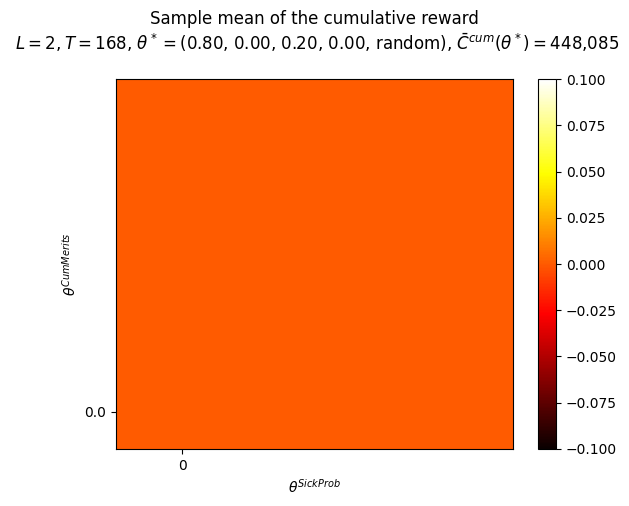

In [ ]:
if 'TRAIN' in cf.MODES:
  ## P.plot_Fhat_map_5(
  # Policy(None).plot_Fhat_map_4(
  V.plot_Fhat_map_4(
    FhatI_theta_I=Cbarcum_Alloc,

    ## thetasX=thetasCumSlots,
    thetasX=ThetasSickProb,
    thetasY=ThetasCumMerits,

    ## labelX=r'$\theta^{CumSlots}$',
    labelX=r'$\theta^{SickProb}$',
    labelY=r'$\theta^{CumMerits}$',

    title="Sample mean of the cumulative reward"+f"\n $L={L}, T={T}$, "+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[3]:,.2f}')+", "+ \
        f'{Best_theta_Alloc[4]}'+"), " \
      r"$\bar{C}^{cum}(\theta^*) =$"+f"{Best_Cbarcum_Alloc:,.0f}\n",
    ## thetaFixed1=best_theta_Alloc.thCumMerits,
    ## thetaFixed1=best_theta_Alloc.thSickProb,
    ## thetaFixed1=best_theta_Alloc.thCumSlots,
    thetaFixed1=Best_theta_Alloc.thContSlots,
    thetaFixed2=Best_theta_Alloc.thSelect,
  )

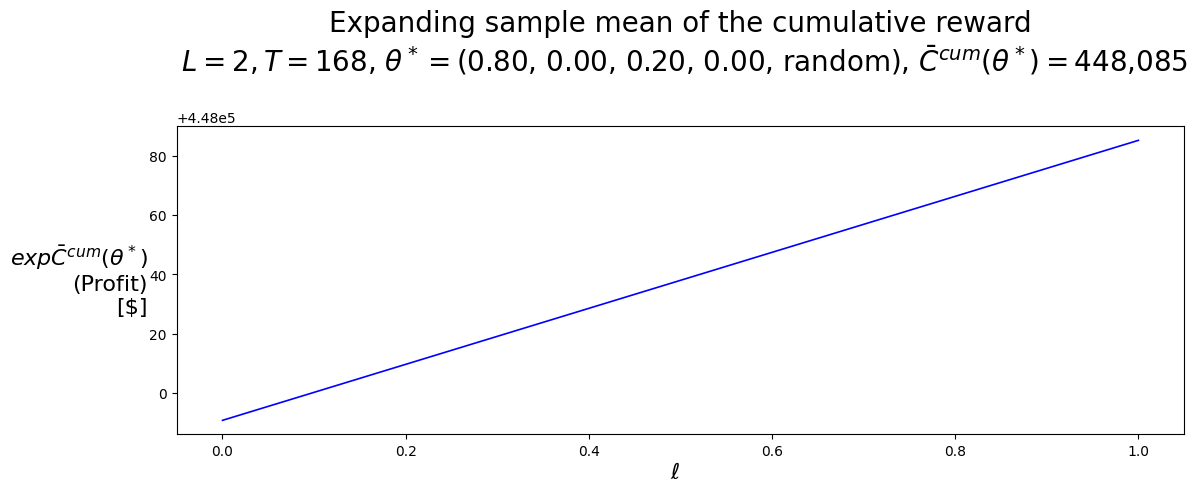

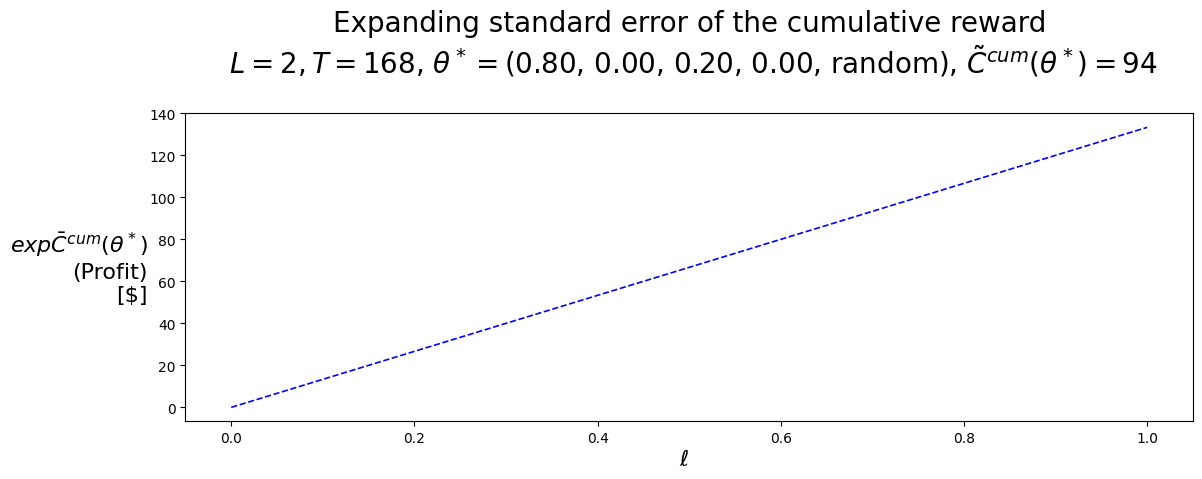

In [ ]:
if 'TRAIN' in cf.MODES:
  # Policy(None).plot_expFhat_chart(
  V.plot_expFhat_chart(
    df=ThetaStar_expCbarcum_Alloc,
    labelX=r'$\ell$',
    labelY=r"$exp\bar{C}^{cum}(\theta^*)$"+"\n(Profit)\n[$]",
    title="Expanding sample mean of the cumulative reward"+f"\n $L={L}, T={T}$, "+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[3]:,.2f}')+", "+
        f'{Best_theta_Alloc[4]}'+"), " \
      r"$\bar{C}^{cum}(\theta^*) =$"+f"{Best_Cbarcum_Alloc:,.0f}\n",
    color_style='b-'
  )
  print()
  # Policy(None).plot_expFhat_chart(
  V.plot_expFhat_chart(    
    df=ThetaStar_expCtilcum_Alloc,
    labelX=r'$\ell$',
    labelY=r"$exp\bar{C}^{cum}(\theta^*)$"+"\n(Profit)\n[$]",
    title="Expanding standard error of the cumulative reward"+f"\n $L={L}, T={T}$, "+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[3]:,.2f}')+", "+
        f'{Best_theta_Alloc[4]}'+"), " \
      r"$\tilde{C}^{cum}(\theta^*) =$"+f"{Best_Ctilcum_Alloc:,.0f}\n",
    color_style='b--'
  )

In [ ]:
if 'TRAIN' in cf.MODES: print(f'{len(Record_Alloc):,}', L, T)

11,760 2 168


In [ ]:
if 'TRAIN' in cf.MODES: print(Best_theta_Alloc)

Theta(thCumSlots=0.8, thSickProb=0, thCumMerits=0.2, thContSlots=0.0, thSelect='random')


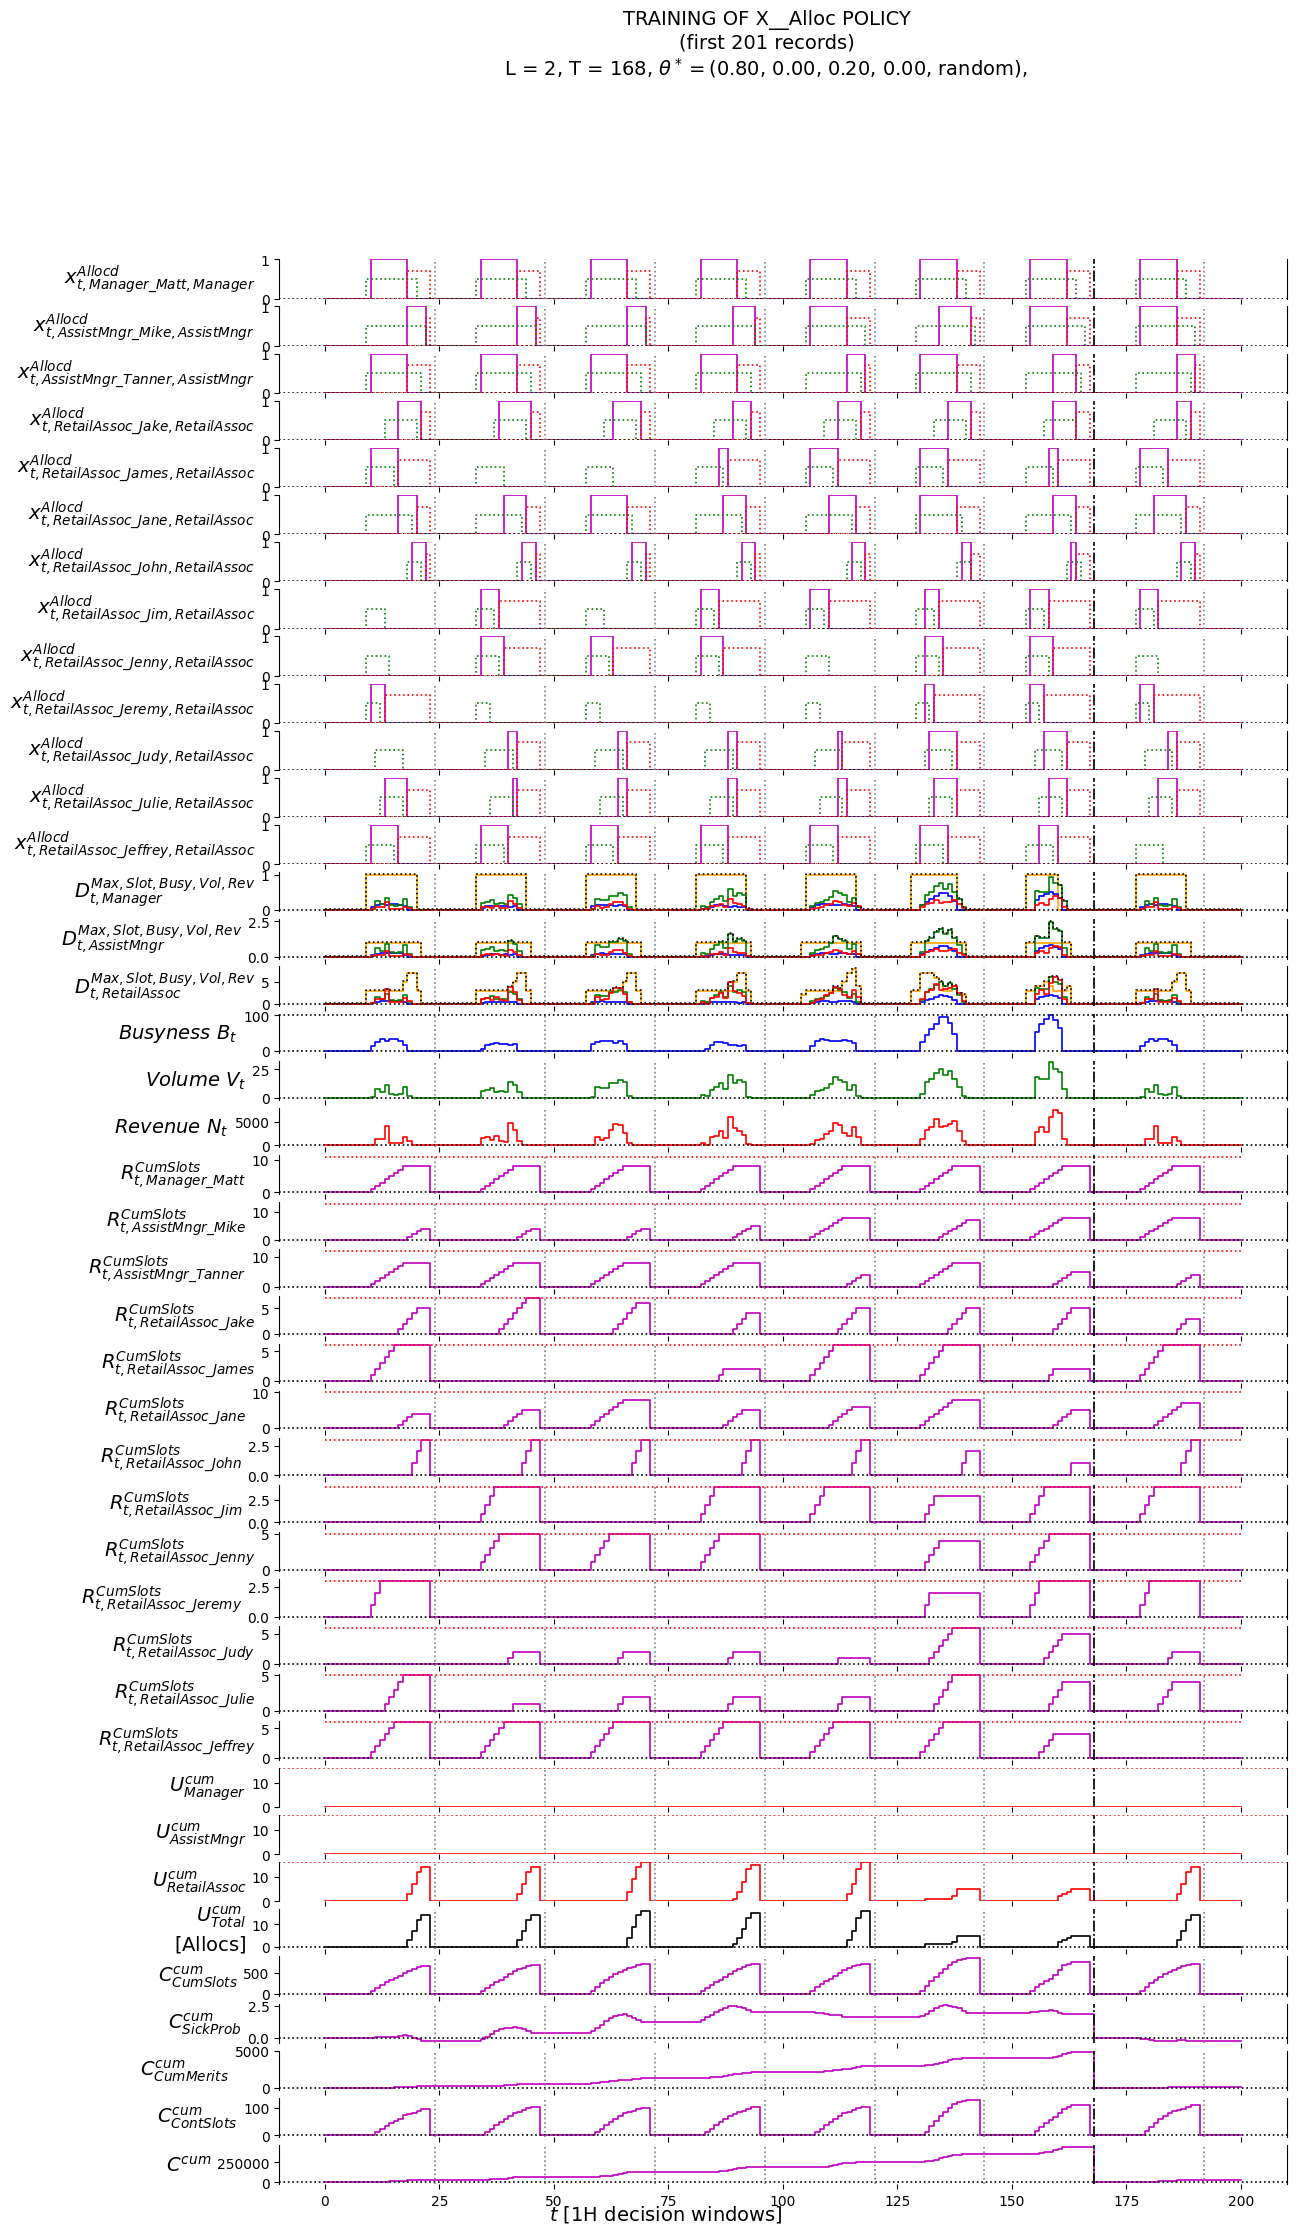

In [ ]:
if 'TRAIN' in cf.MODES:
  # Policy(None).plot_records(
  V.plot_records(    
    df=Df_first_n_t,
    df_non=None,
    pars=defaultdict(str, {
      'T': T,
      'xlabel': "$t\ \mathrm{["+f"{cf.DATE_TIME_DELTA}"+"\ decision\ windows]}$",
      'thCumSlots': Best_theta_Alloc.thCumSlots,
      'thSickProb': Best_theta_Alloc.thSickProb,
      ## 'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
      'suptitle': f'TRAINING OF X__Alloc POLICY'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
      f'L = {L}, T = {T}, '+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[3]:,.2f}')+", "+
        f'{Best_theta_Alloc[4]}'+"), " \
    }),
  );

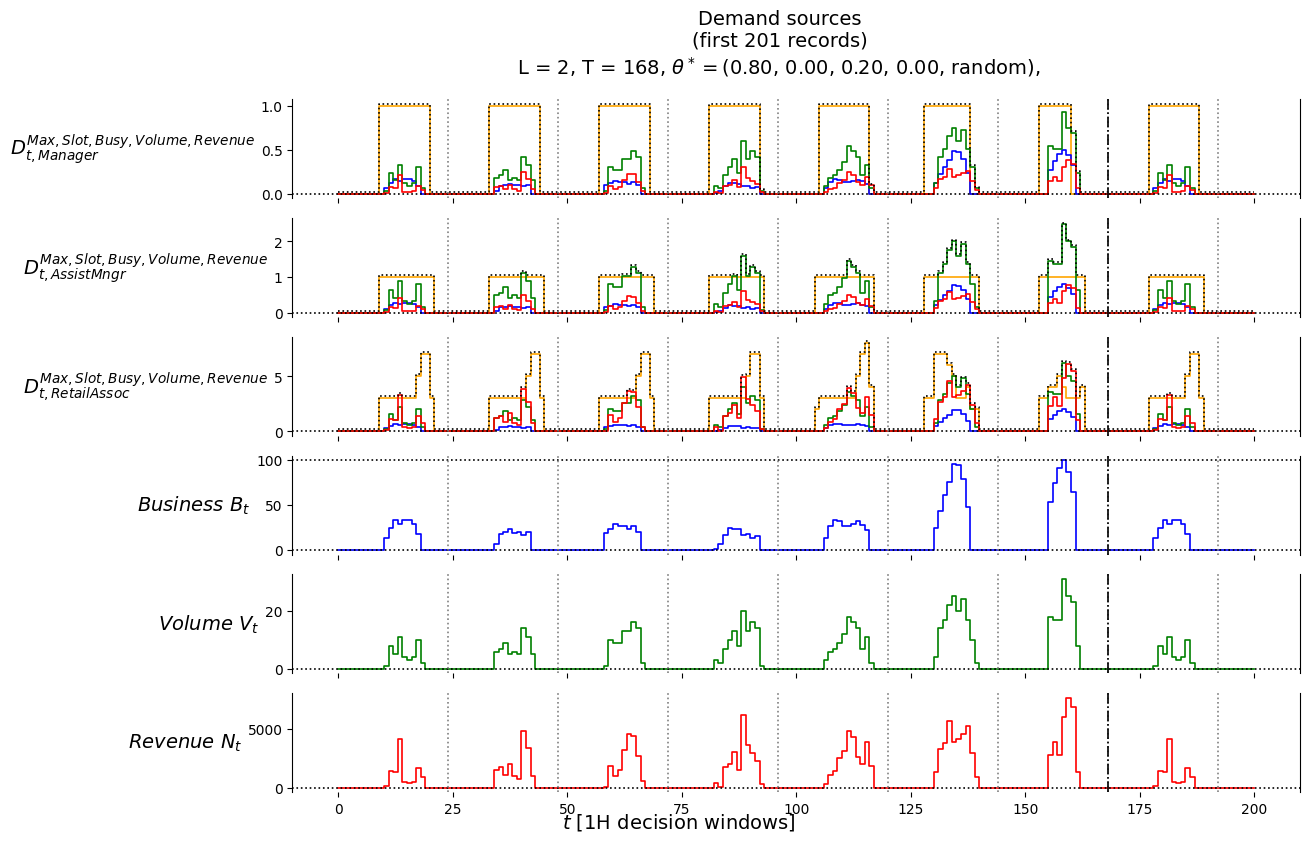

In [ ]:
if 'TRAIN' in cf.MODES:
  # Policy(None).plot_demand_sources(
  V.plot_demand_sources(
    df=Df_first_n_t,
    pars=defaultdict(str, {
      'T': T, 
      'xlabel': "$t\ \mathrm{["+f"{cf.DATE_TIME_DELTA}"+"\ decision\ windows]}$",
      'suptitle': f'Demand sources'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
      f'L = {L}, T = {T}, '+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[3]:,.2f}')+", "+
        f'{Best_theta_Alloc[4]}'+"), " \
    }),
  );

In [ ]:
if 'TRAIN' in cf.MODES: print(T, cf.SLOTS_PER_DAY)

168 24


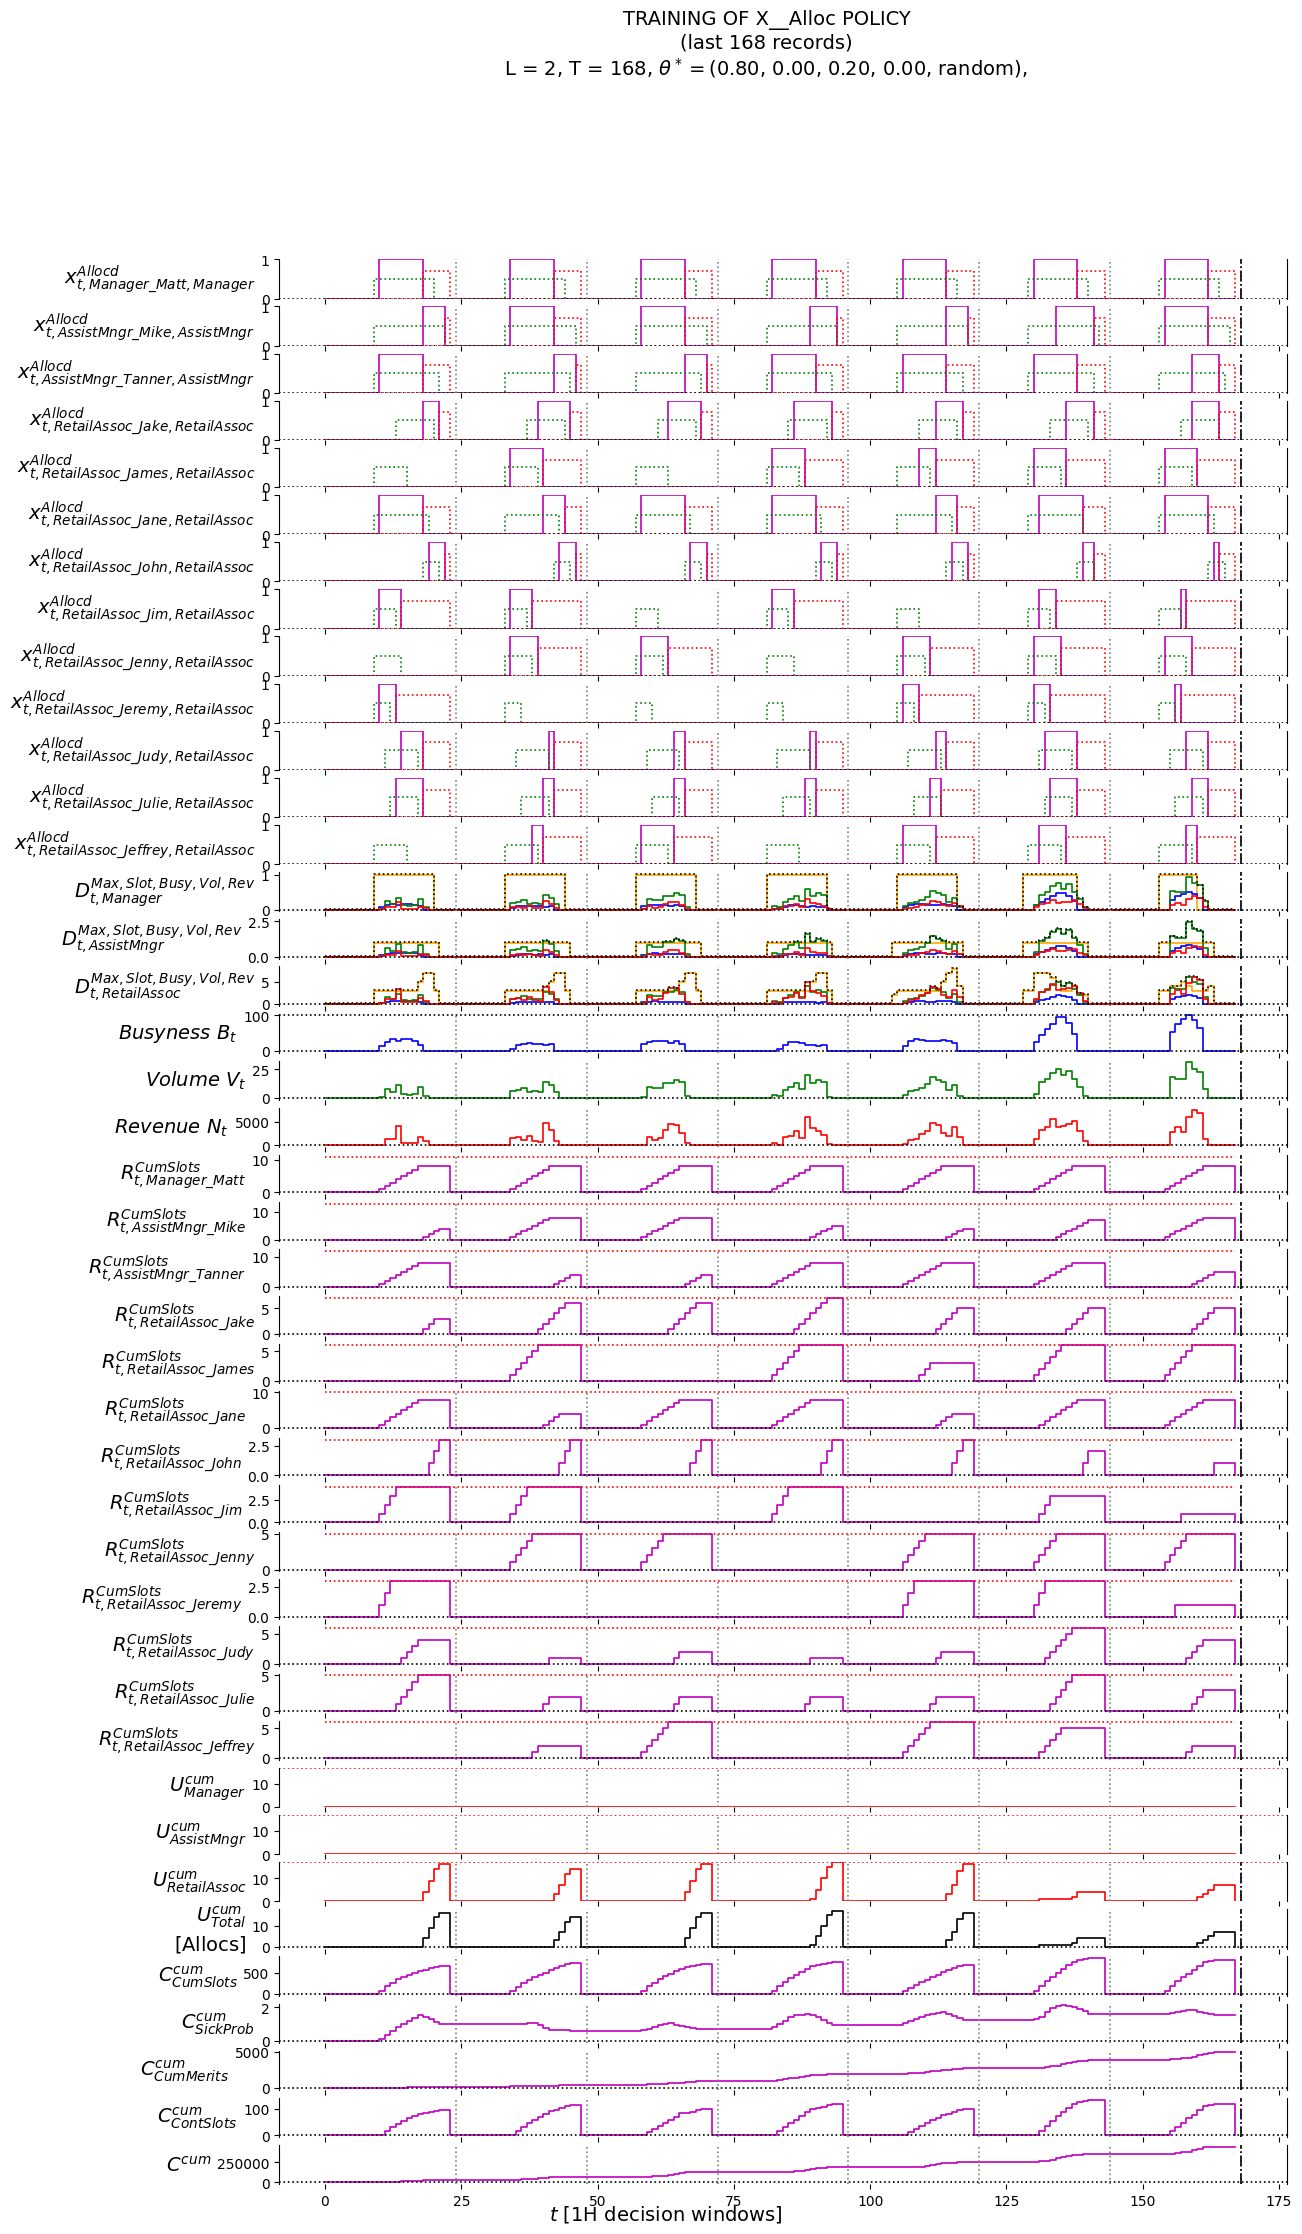

In [ ]:
if 'TRAIN' in cf.MODES:
  # Policy(None).plot_records(
  V.plot_records(    
    df=Df_last_n_t,
    df_non=None,
    pars=defaultdict(str, {
      'T': T, 
      'thCumSlots': Best_theta_Alloc.thCumSlots,
      'thSickProb': Best_theta_Alloc.thSickProb,
      ## 'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
      'xlabel': "$t\ \mathrm{["+f"{cf.DATE_TIME_DELTA}"+"\ decision\ windows]}$",
      'suptitle': f'TRAINING OF X__Alloc POLICY'+'\n'+f'(last {Last_n_t} records)'+'\n'+ \
      f'L = {L}, T = {T}, '+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[3]:,.2f}')+", "+
        f'{Best_theta_Alloc[4]}'+"), " \
    }),
  )

#### 4.6.1.2 Comparison of Policies

In [ ]:
## hide
## last_n_l = int(.95*L)
## P.plot_expFhat_charts(
#   means={
#       'HighLow': thetaStar_expCbarcum_HighLow[-last_n_l:],
#       'SellLow': thetaStar_expCbarcum_SellLow[-last_n_l:],
#       'Track': thetaStar_expCbarcum_Track[-last_n_l:]
#   },
#   stdvs={
#       'HighLow': thetaStar_expCtilcum_HighLow[-last_n_l:],
#       'SellLow': thetaStar_expCtilcum_SellLow[-last_n_l:],
#       'Track': thetaStar_expCtilcum_Track[-last_n_l:]
#   },
#   labelX='Sample paths, ' + r'$\ell$',
#   labelY='Profit\n[$]',
#   suptitle=f"Comparison of Policies after Training\n \
#     L = {L}, T = {T}\n \
#     last {last_n_l} records\n \
#     ('exp' refers to expanding)",
#   pars=defaultdict(str, {
#     'colors': ['r', 'g', 'b']
#   }),
# )

#### 4.6.2 Evaluation

##### 4.6.2.1 X__AllocBelow

In [ ]:
if 'EVALU' in cf.MODES: print(Best_theta_Alloc)

Theta(thCumSlots=0.8, thSickProb=0, thCumMerits=0.2, thContSlots=0.0, thSelect='random')


In [ ]:
if 'EVALU' in cf.MODES: print(Worst_theta_Alloc)

Theta(thCumSlots=0.0, thSickProb=1, thCumMerits=0.0, thContSlots=0.0, thSelect='random')


In [ ]:
# # ///
# # def do_evalu(): !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# def do_evalu(L, T):
#   # global DEM, MER, \
#   global ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
#   Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
#   Record_Alloc_evalu_opt, Df_Alloc_evalu_opt, \
#   ThetaStar_expCbarcum_Alloc_evalu_non, ThetaStar_expCtilcum_Alloc_evalu_non, \
#   Best_theta_Alloc_evalu_non, Worst_theta_Alloc_evalu_non, \
#   Record_Alloc_evalu_non, Df_Alloc_evalu_non

#   M = Model()
#   P = Policy(M)
#   ## DEM = DemandSimulator(seed=SEED_EVALU)
#   ## MER = MeritSimulator(seed=SEED_EVALU)
#   thetasOpt = []; thetasOpt.append(Best_theta_Alloc)
#   ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
#   _, _, \
#   Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
#   _, _, \
#   _, _, \
#   Record_Alloc_evalu_opt = \
#     P.perform_grid_search_sample_paths('X__Alloc', thetasOpt, L, T)
#   Df_Alloc_evalu_opt = pd.DataFrame.from_records(
#       Record_Alloc_evalu_opt[:First_n_t], columns=Labels)

#   M = Model()
#   P = Policy(M)
#   ## DEM = DemandSimulator(seed=SEED_EVALU)
#   ## MER = MeritSimulator(seed=SEED_EVALU)
#   thetasNon = []; thetasNon.append(Worst_theta_Alloc)
#   ## thetasNon = []; thetasNon.append(
#   ##   P.build_theta(
#   ##     {'thCumShifts': 1.0, 'thSickProb': 1.0}
#   ##   )
#   ## )
#   ThetaStar_expCbarcum_Alloc_evalu_non, ThetaStar_expCtilcum_Alloc_evalu_non, \
#   _, _, \
#   Best_theta_Alloc_evalu_non, Worst_theta_Alloc_evalu_non, \
#   _, _, \
#   _, _, \
#   Record_Alloc_evalu_non = \
#     P.perform_grid_search_sample_paths('X__Alloc', thetasNon, L, T)
#   Df_Alloc_evalu_non = pd.DataFrame.from_records(
#       Record_Alloc_evalu_non[:First_n_t], columns=Labels)

#   print(
#     f'{ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=:.2f}, \
#       {ThetaStar_expCbarcum_Alloc_evalu_non.iloc[-1]=:.2f}')

In [ ]:
# # ///
# %%time
# ## Wall time: 3min 13s [colab]
# ## Wall time: 2min 1s [mac mini]
# ## It is the thetas that are done in parallel, so no parallel speedup here (actually a bit longer
# ## due to the ray shutdown and init).
# ## There is a SINGLE theta for each of the 2 cases.
# ## During training, where there are multiple thetas, there will be a speedup.
# if 'EVALU' in cf.MODES:
#   L = 2 #20 #5 #2 #2db #10pub
#   T = 7*cf.SLOTS_PER_DAY #=672
#   First_n_t = int(.11*L*T)
#   # do_evalu() !!!!!!!!!!!!!!!!!!!!!!!!!!!
#   do_evalu(L, T)

In [ ]:
%%time
## to test
# if 'EVALU' in cf.MODES:
L = 2 #20 #5 #2 #2db #10pub
T = 7*cf.SLOTS_PER_DAY #=672
First_n_t = int(.11*L*T)

ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
_, _, \
Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
_, _, \
_, _, \
Record_Alloc_evalu_opt = \
  evl.do_evalu_opt(L, T, Best_theta_Alloc)

Df_Alloc_evalu_opt = pd.DataFrame.from_records(
  Record_Alloc_evalu_opt[:First_n_t], columns=Labels)
print(f'{ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=:.2f}')

numThetas=1
... printing every 1th theta (if considered) ...
	%%% l=1
	%%% l=2
0/0, 447,825, Theta(thCumSlots=0.8, thSickProb=0, thCumMerits=0.2, thContSlots=0.0, thSelect='random')
ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=447825.03
CPU times: user 17.5 s, sys: 60.4 ms, total: 17.6 s
Wall time: 17.7 s


In [ ]:
%%time
## to test
# if 'EVALU' in cf.MODES:
L = 2 #20 #5 #2 #2db #10pub
T = 7*cf.SLOTS_PER_DAY #=672
First_n_t = int(.11*L*T)

ThetaStar_expCbarcum_Alloc_evalu_non, ThetaStar_expCtilcum_Alloc_evalu_non, \
_, _, \
Best_theta_Alloc_evalu_non, Worst_theta_Alloc_evalu_non, \
_, _, \
_, _, \
Record_Alloc_evalu_non = \
  evl.do_evalu_non(L, T, Worst_theta_Alloc)

Df_Alloc_evalu_non = pd.DataFrame.from_records(
  Record_Alloc_evalu_non[:First_n_t], columns=Labels)
print(f'{ThetaStar_expCbarcum_Alloc_evalu_non.iloc[-1]=:.2f}')

numThetas=1
... printing every 1th theta (if considered) ...
	%%% l=1
	%%% l=2
0/0, 442,897, Theta(thCumSlots=0.0, thSickProb=1, thCumMerits=0.0, thContSlots=0.0, thSelect='random')
ThetaStar_expCbarcum_Alloc_evalu_non.iloc[-1]=442896.88
CPU times: user 17.4 s, sys: 60.5 ms, total: 17.5 s
Wall time: 17.5 s


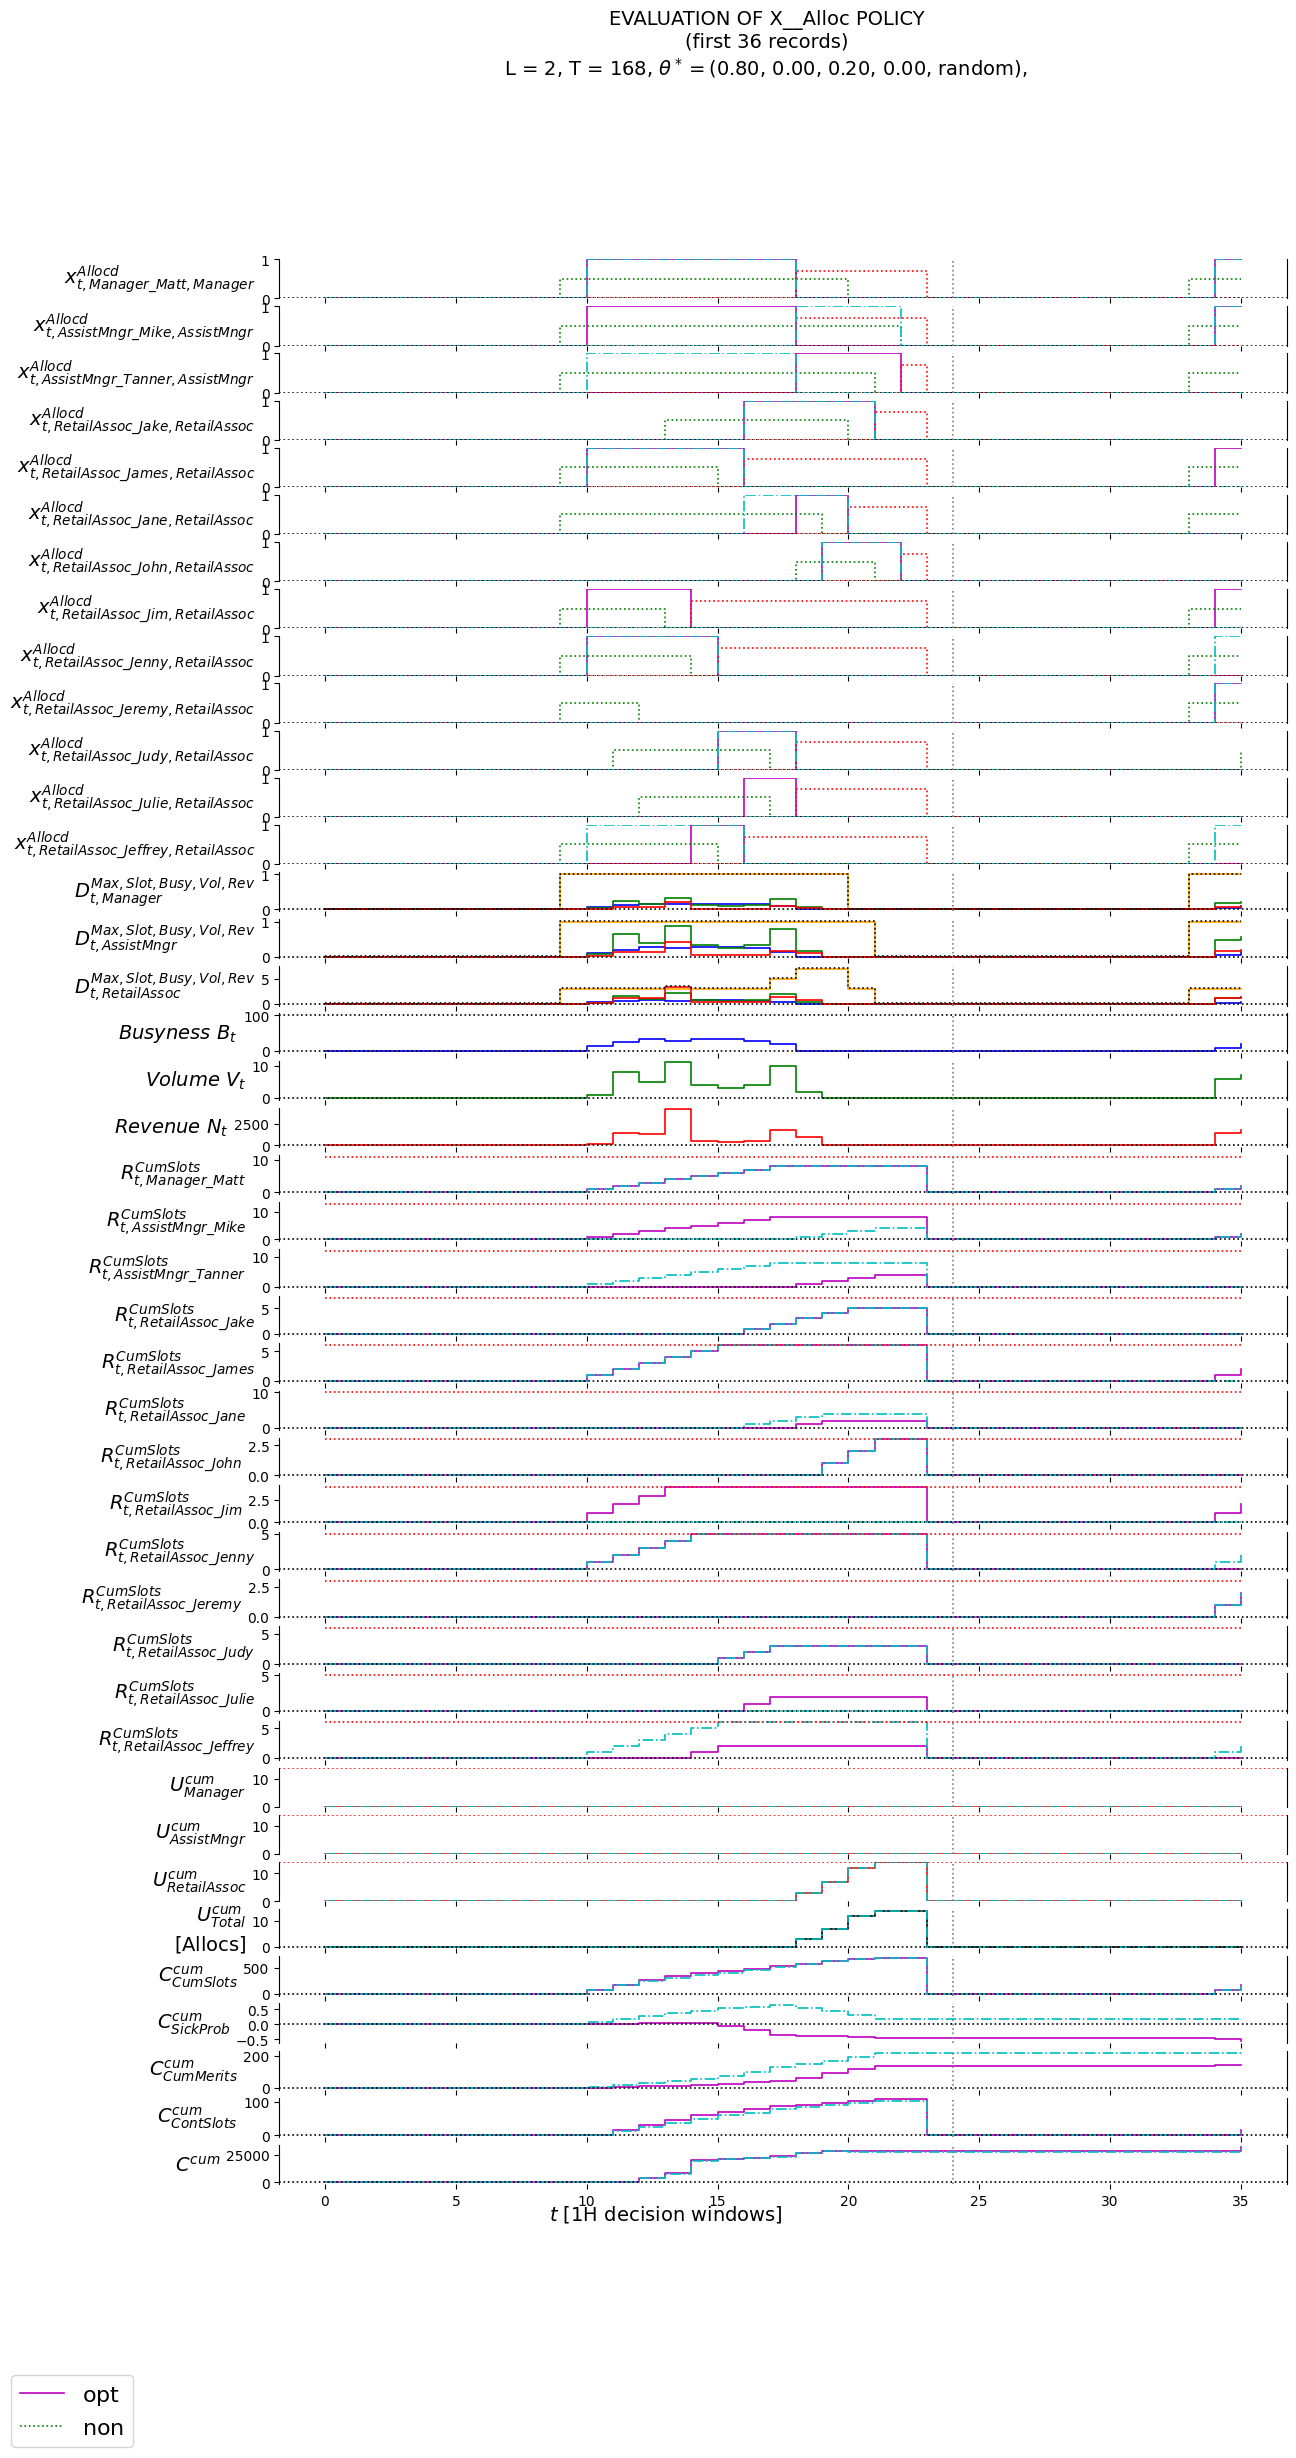

In [ ]:
if 'EVALU' in cf.MODES:
  # Policy(None).plot_records(
  V.plot_records(  
    df=Df_Alloc_evalu_opt,
    df_non=Df_Alloc_evalu_non,
    pars=defaultdict(str, {
      'T': T,
      'thCumSlots': Best_theta_Alloc_evalu_opt.thCumSlots,
      'thSickProb': Best_theta_Alloc_evalu_opt.thSickProb,
      'thCumSlotsNon': Best_theta_Alloc_evalu_non.thCumSlots,
      'thSickProbNon': Best_theta_Alloc_evalu_non.thSickProb,
      'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
      'xlabel': "$t\ \mathrm{["+f"{cf.DATE_TIME_DELTA}"+"\ decision\ windows]}$",
      'suptitle': f'EVALUATION OF X__Alloc POLICY'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
      f'L = {L}, T = {T}, '+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc_evalu_opt[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[3]:,.2f}')+", "+
        f'{Best_theta_Alloc_evalu_opt[4]}'+"), " \
    }),
  )

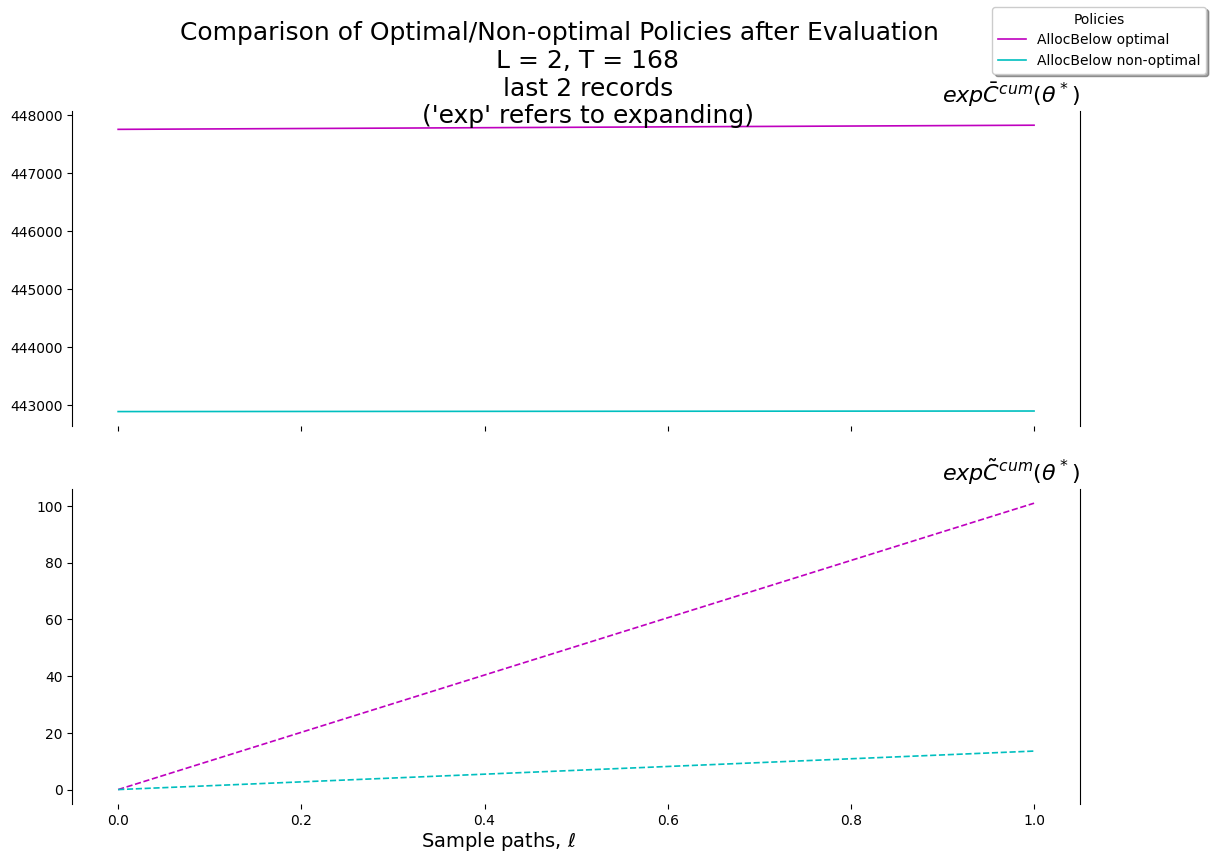

In [ ]:
if 'EVALU' in cf.MODES:
  ## last_n_l = int(.99*L)
  Last_n_l = int(1.0*L)
  # Policy(None).plot_expFhat_charts(
  V.plot_expFhat_charts(
    means={
        'AllocBelow optimal': ThetaStar_expCbarcum_Alloc_evalu_opt[-Last_n_l:],
        'AllocBelow non-optimal': ThetaStar_expCbarcum_Alloc_evalu_non[-Last_n_l:],
    },
    stdvs={
        'AllocBelow optimal': ThetaStar_expCtilcum_Alloc_evalu_opt[-Last_n_l:],
        'AllocBelow non-optimal': ThetaStar_expCtilcum_Alloc_evalu_non[-Last_n_l:],
    },
    labelX='Sample paths, ' + r'$\ell$',
    ## labelY='Profit\n[Allocs]',
    labelY='',
    suptitle=f"Comparison of Optimal/Non-optimal Policies after Evaluation\n \
      L = {L}, T = {T}\n \
      last {Last_n_l} records\n \
      ('exp' refers to expanding)",
    pars=defaultdict(str, {
      'colors': ['m', 'c']
    }),
  )

Next, we evaluate with a single sample-path:

In [ ]:
# # ///
# %%time
# ## will show error due to division by 0 because L=1; OK for our purposes
# ## 1min 31s [colab]
# ## 1min 5s  [mac mini]
# if 'EVALU' in cf.MODES:
#   L = 1
#   T = 7*cf.SLOTS_PER_DAY
#   First_n_t = int(1*L*T)
#   # do_evalu() !!!!!!!!!!!!!!!!!!!!!
#   do_evalu(L, T)

In [ ]:
# /////////////////////////////////////

In [ ]:
%%time
## to test
# if 'EVALU' in cf.MODES:
L = 1 #20 #5 #2 #2db #10pub
T = 7*cf.SLOTS_PER_DAY #=672
First_n_t = int(1*L*T)

ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
_, _, \
Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
_, _, \
_, _, \
Record_Alloc_evalu_opt = \
  evl.do_evalu_opt(L, T, Best_theta_Alloc)

Df_Alloc_evalu_opt = pd.DataFrame.from_records(
  Record_Alloc_evalu_opt[:First_n_t], columns=Labels)
print(f'{ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=:.2f}')

numThetas=1
... printing every 1th theta (if considered) ...
	%%% l=1
0/0, 445,675, Theta(thCumSlots=0.8, thSickProb=0, thCumMerits=0.2, thContSlots=0.0, thSelect='random')
ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=445674.77
CPU times: user 8.96 s, sys: 41.4 ms, total: 9 s
Wall time: 9 s


/Users/kobus/AIShiftScheduler_KE5/AIShiftScheduler_KE5/policy.py:212: RuntimeWarning: invalid value encountered in scalar divide
  Ctilcum_tmp = np.sum(np.square(np.array(CcumIomega__lI) - Cbarcum_tmp))/(L - 1)


In [ ]:
%%time
## to test
# if 'EVALU' in cf.MODES:
L = 1 #20 #5 #2 #2db #10pub
T = 7*cf.SLOTS_PER_DAY #=672
First_n_t = int(1*L*T)

ThetaStar_expCbarcum_Alloc_evalu_non, ThetaStar_expCtilcum_Alloc_evalu_non, \
_, _, \
Best_theta_Alloc_evalu_non, Worst_theta_Alloc_evalu_non, \
_, _, \
_, _, \
Record_Alloc_evalu_non = \
  evl.do_evalu_non(L, T, Worst_theta_Alloc)

Df_Alloc_evalu_non = pd.DataFrame.from_records(
  Record_Alloc_evalu_non[:First_n_t], columns=Labels)
print(f'{ThetaStar_expCbarcum_Alloc_evalu_non.iloc[-1]=:.2f}')

numThetas=1
... printing every 1th theta (if considered) ...
	%%% l=1
0/0, 442,903, Theta(thCumSlots=0.0, thSickProb=1, thCumMerits=0.0, thContSlots=0.0, thSelect='random')
ThetaStar_expCbarcum_Alloc_evalu_non.iloc[-1]=442902.58
CPU times: user 8.7 s, sys: 31.7 ms, total: 8.73 s
Wall time: 8.75 s


/Users/kobus/AIShiftScheduler_KE5/AIShiftScheduler_KE5/policy.py:212: RuntimeWarning: invalid value encountered in scalar divide
  Ctilcum_tmp = np.sum(np.square(np.array(CcumIomega__lI) - Cbarcum_tmp))/(L - 1)


In [ ]:
# \\\\\\\\\\\\\\\

In [ ]:
if 'EVALU' in cf.MODES: print(L, T, cf.RESOLUTION)

1 168 HOUR


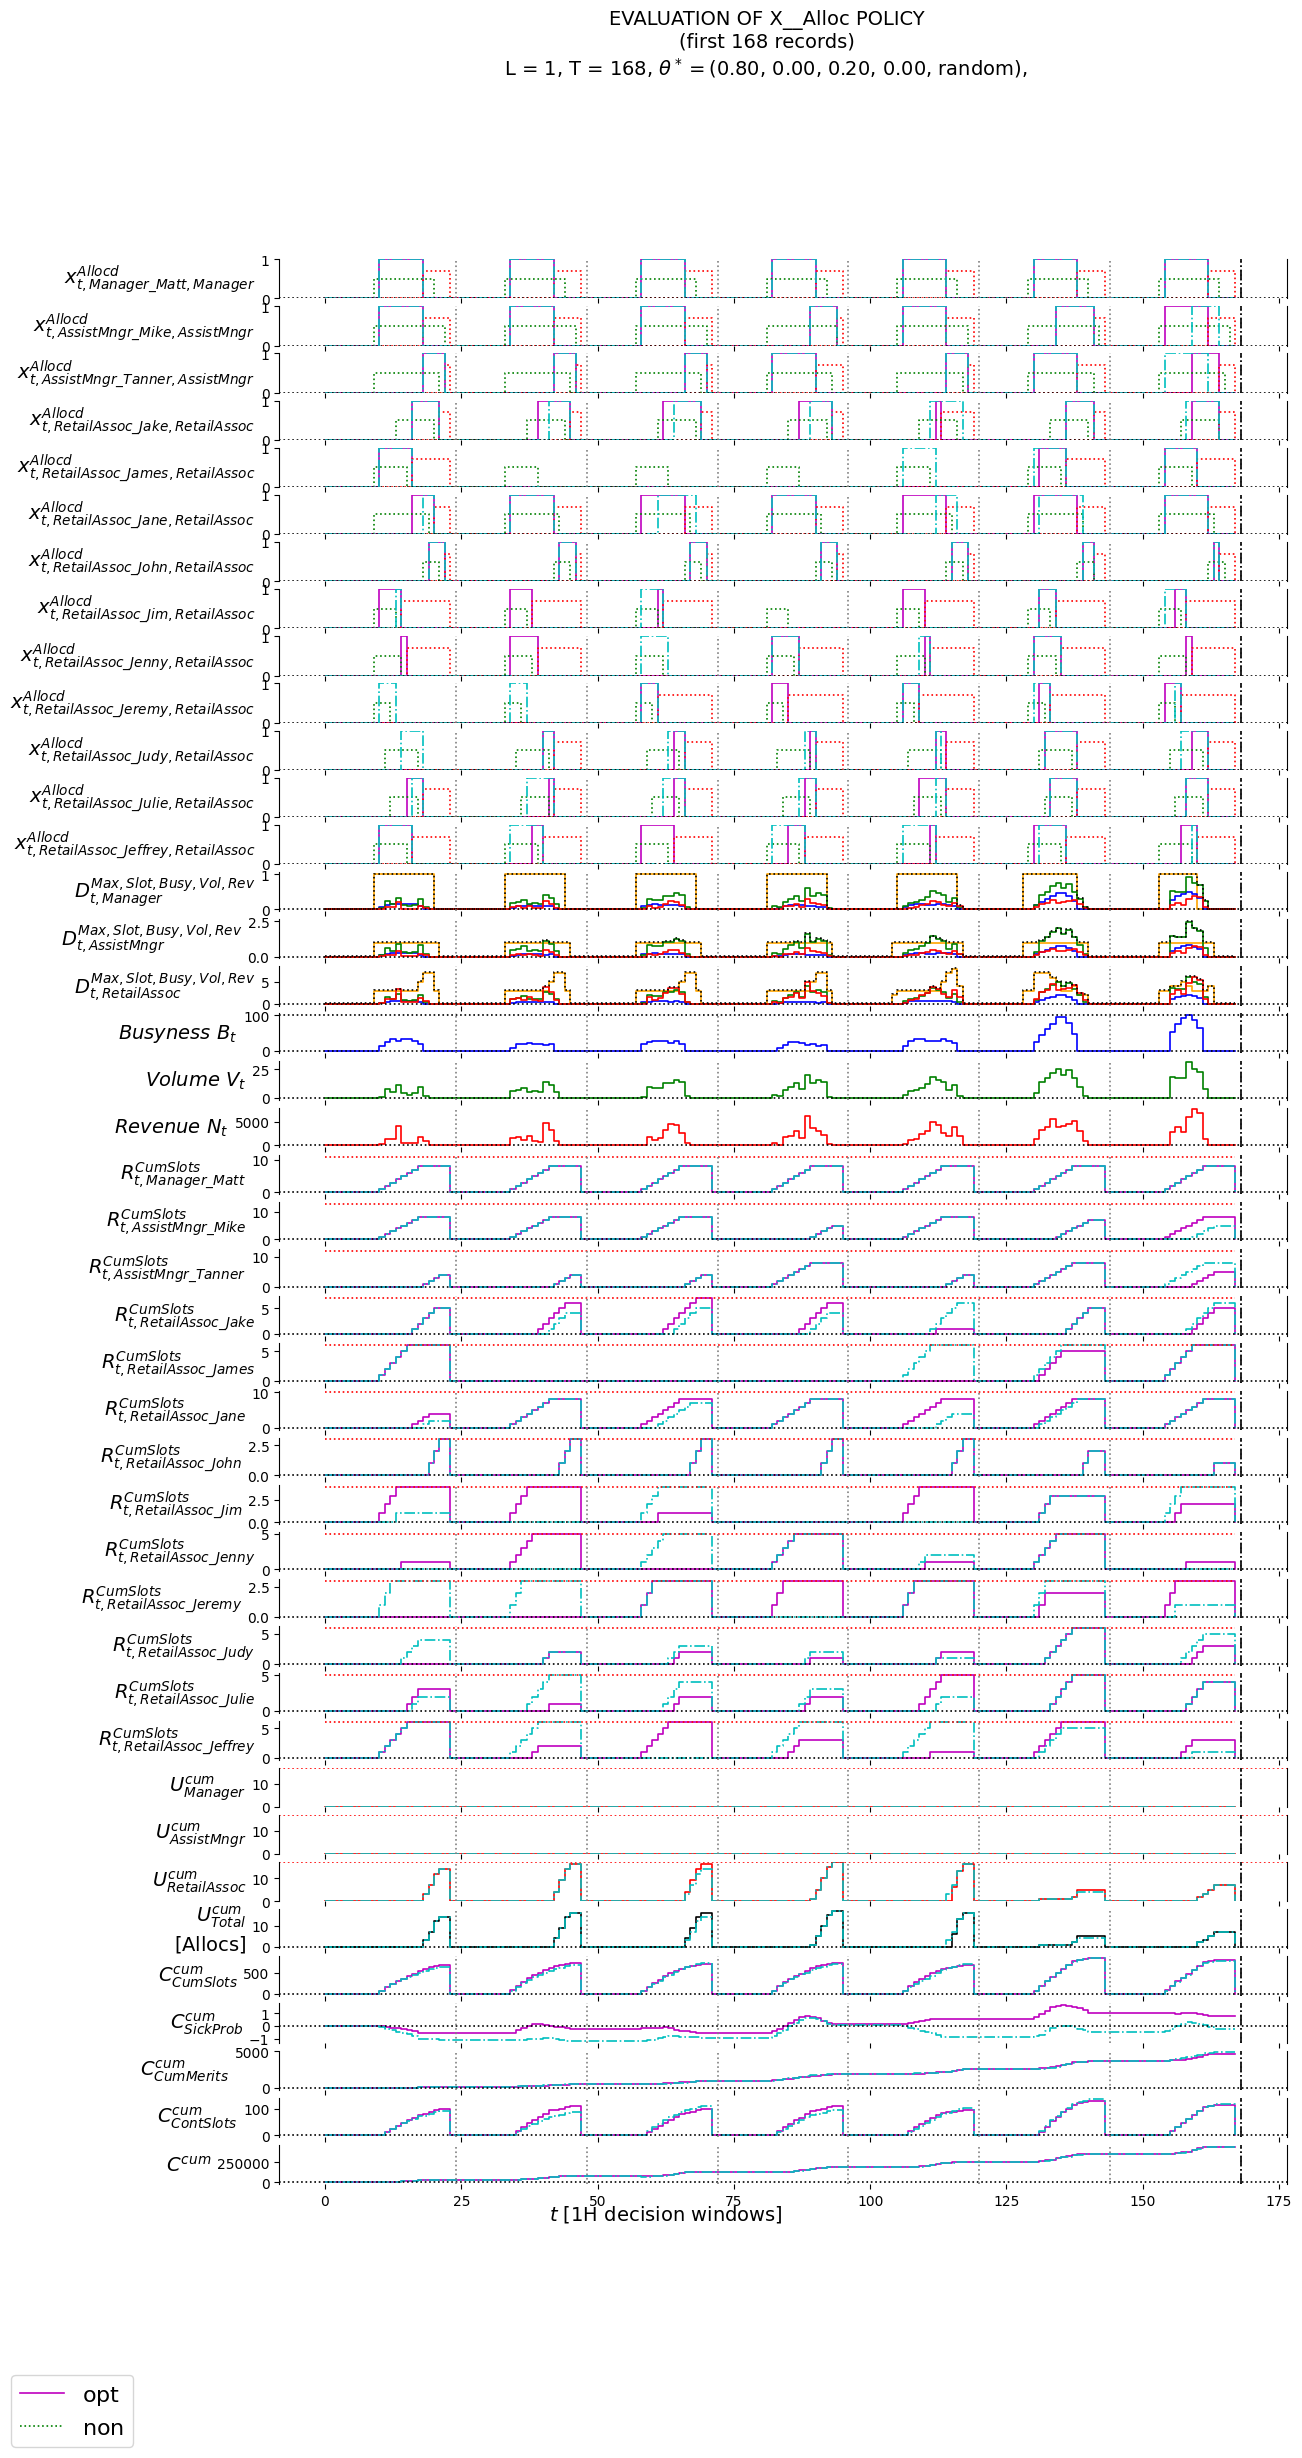

In [ ]:
if 'EVALU' in cf.MODES:
  # Policy(None).plot_records(
  V.plot_records(
    df=Df_Alloc_evalu_opt,
    df_non=Df_Alloc_evalu_non, 
    ## df_non=None,
    pars=defaultdict(str, {
      'T': T,
      'thCumSlots': Best_theta_Alloc_evalu_opt.thCumSlots,
      'thSickProb': Best_theta_Alloc_evalu_opt.thSickProb,
      'thCumSlotsNon': Best_theta_Alloc_evalu_non.thCumSlots,
      'thSickProbNon': Best_theta_Alloc_evalu_non.thSickProb,
      'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
      'xlabel': "$t\ \mathrm{["+f"{cf.DATE_TIME_DELTA}"+"\ decision\ windows]}$",
      'suptitle': f'EVALUATION OF X__Alloc POLICY'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
      f'L = {L}, T = {T}, '+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc_evalu_opt[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[3]:,.2f}')+", "+
        f'{Best_theta_Alloc_evalu_opt[4]}'+"), " \
    }),
  )

In [ ]:
if 'EVALU' in cf.MODES:
  print(Df_Alloc_evalu_opt[Df_Alloc_evalu_opt['t']==T-1][['Ccum']])

            Ccum
167 445,674.7700


In [ ]:
if 'EVALU' in cf.MODES:
  print(Df_Alloc_evalu_non[Df_Alloc_evalu_non['t']==T-1][['Ccum']])

            Ccum
167 442,902.5820


From the `Ccum` plot we see that the cumulative reward for the optimal policy keeps on rising. The non-optimal policy does not do as well.

#### 4.6.3 Comparison of Optimized Policies

In [ ]:
## hide
## P.plot_evalu_comparison(
#   df1=df_BuyBelow_evalu_opt,
#   df2=df_Bellman_evalu_opt,
#   df3=None,
#   pars= defaultdict(str, {
#     'suptitle': f'EVALUATION OF ALL POLICIES (first {first_n_t} records)\n \
#     L={L}, T={T}',
#   }),
# )

## 5 EVALUATION

In [ ]:
def print_schedule_shifts(df):
  mask = df.columns.str.contains('Allocd_t')
  resource_allocs = list(df.columns[mask])
  sched = copy(df)
  schedule = sched[['dt']+resource_allocs]

  print(f"SCHEDULE SHIFTS:")
  print(f"===============")
  for res_alloc in resource_allocs:
    _,_,id,resType,_,_,_ = res_alloc.split('_')
    resName = id+'_'+resType
    print(f'\n************** {resName}:')
    sched_list = list(schedule.loc[
      schedule[res_alloc] == True,
      ['dt', res_alloc]
    ]['dt'])
    if len(sched_list) > 0:
      ts_1 = sched_list[0]
      dow_1 = sched_list[0].day_of_week
      print(f"{(sched_list[0]-pd.Timedelta(cf.DATE_TIME_DELTA)).strftime('%a %b %d %Hh%M')}")
      for ts in sched_list:
        dow = ts.day_of_week
        if dow != dow_1:
          print(f"{(ts_1).strftime('%a %b %d %Hh%M')}\n")
          print(f"{(ts-pd.Timedelta(cf.DATE_TIME_DELTA)).strftime('%a %b %d %Hh%M')}")
        dow_1 = dow
        ts_1 = ts
      print(f"{(sched_list[-1]).strftime('%a %b %d %Hh%M')}")
  print(f'\n{cf.CONTIGUOUS_REWARD=}')
  print(f'{cf.MAX_DAILY_SLOT_RUN=} ({cf.RESOLUTION}s)')
  print(f'{cf.TH_CumSlots_SPEC=}')
  print(f'{cf.TH_SickProb_SPEC=}')
  print(f'{cf.TH_CumMerits_SPEC=}')
  print(f'{cf.TH_ContSlots_SPEC=}')
  print(f'{cf.TH_Select_SPEC=}')

In [ ]:
##
# if 'EVALU' in cf.MODES:
#   print_schedule_shifts(Df_Alloc_evalu_opt)

In [ ]:
def gap_minutes(resolution):
  if resolution == 'QUARTER_HOUR':
    return 15
  elif resolution == 'HOUR':
    return 60
  elif resolution == 'BLOCK_8_HOUR':
    return 480
  else:
    print(f'ERROR: Invalid RESOLUTION: {cf.RESOLUTION}')

In [ ]:
def print_schedule_slots(df):
  gap_mins = gap_minutes(cf.RESOLUTION)
  mask = df.columns.str.contains('Allocd_t')
  resource_allocs = list(df.columns[mask])
  sched = copy(df)
  schedule = sched[['dt']+resource_allocs]

  print(f"SCHEDULE SLOTS:")
  print(f"===============")
  n_gaps = 0
  for res_alloc in resource_allocs:
    _,_,id,resType,_,_,_ = res_alloc.split('_')
    resName = id+'_'+resType
    print(f'\n************** {resName}:')
    sched_list = list(schedule.loc[
      schedule[res_alloc] == True,
      ['dt', res_alloc]
    ]['dt'])
    if len(sched_list) > 0:
      ## print each slot and indicate gaps
      ts_1 = sched_list[0]
      dow_1 = -1
      for ts in sched_list:
        dow = ts.day_of_week
        if dow != dow_1: print('')
        if (int((ts.to_datetime64() - ts_1.to_datetime64())/(1e9*60)) > gap_mins)\
          and (dow == dow_1):
          n_gaps += 1
          print(f"{(ts-pd.Timedelta(cf.DATE_TIME_DELTA)).strftime('%a %b %d %Hh%M')} GAP")
        else:
          print(f"{(ts-pd.Timedelta(cf.DATE_TIME_DELTA)).strftime('%a %b %d %Hh%M')}")
        dow_1 = dow
        ts_1 = ts
  print(f'\nTOTAL NUMBER OF GAPS FOR ALL RESOURCES: {n_gaps}')
  print(f'{cf.CONTIGUOUS_REWARD=}')
  print(f'{cf.MAX_DAILY_SLOT_RUN=} ({cf.RESOLUTION}s)')
  print(f'{cf.TH_CumSlots_SPEC=}')
  print(f'{cf.TH_SickProb_SPEC=}')
  print(f'{cf.TH_CumMerits_SPEC=}')
  print(f'{cf.TH_ContSlots_SPEC=}')
  print(f'{cf.TH_Select_SPEC=}')

In [ ]:
##
# if 'EVALU' in cf.MODES:
#   print_schedule_slots(Df_Alloc_evalu_opt)

## 6 DEPLOYMENT | INFERENCE

In [ ]:
#- import AIShiftScheduler_KE5.inferencer as inf

In [ ]:
cf.MODES = 'INFER'

In [ ]:
# #///
# def get_best_theta_Alloc():
#   best_theta_Alloc = \
#     Policy(None).build_theta({
#       'thCumSlots': cf.BEST_THETA_Alloc[0],
#       'thSickProb': cf.BEST_THETA_Alloc[1],
#       'thCumMerits': cf.BEST_THETA_Alloc[2],
#       'thContSlots': cf.BEST_THETA_Alloc[3],
#       'thSelect': cf.BEST_THETA_Alloc[4]
#     })
#   return best_theta_Alloc

In [ ]:
# ##/// def do_apply():
# def do_infer(L, T):
#   global DEM, MER, \
#   ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
#   Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
#   Record_Alloc_evalu_opt, Df_Alloc_evalu_opt

#   M = Model()
#   P = Policy(M)
#   ## DEM = DemandSimulator(seed=SEED_EVALU)
#   ## MER = MeritSimulator(seed=SEED_EVALU)
#   thetasOpt = []; thetasOpt.append(get_best_theta_Alloc()) ##from storage
#   ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
#   _, _, \
#   Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
#   _, _, \
#   _, _, \
#   Record_Alloc_evalu_opt = \
#     P.perform_grid_search_sample_paths('X__Alloc', thetasOpt, L, T)
#     # P.perform_grid_search_sample_paths('X__Alloc', thetasOpt) !!!!!!!!!!!!!!
#   Df_Alloc_evalu_opt = pd.DataFrame.from_records(
#       Record_Alloc_evalu_opt[:First_n_t], columns=Labels)
#   print(
#     f'{ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=:.2f}')

In [ ]:
# #/// %%time
# ## to test
# # cf.MODES = ['LEARN', 'APPLY']
# cf.MODES = ['EVALU', 'INFER']
# if 'INFER' in cf.MODES:
#   L = 1
#   T = 7*cf.SLOTS_PER_DAY
#   First_n_t = int(1*L*T)
#   # do_apply() !!!!!!!!!!!!!!!!!!!!!
#   do_infer(L, T)
#   print_schedule_shifts(Df_Alloc_evalu_opt)

In [ ]:
Df_Alloc_evalu_opt.shape

(168, 97)

In [ ]:
len(Labels)

97

In [ ]:
#/// Record_Alloc_evalu_opt = []
# Record_Alloc_evalu_opt
# del Df_Alloc_evalu_opt

In [ ]:
##from storage
best_theta_Alloc = inf.get_best_theta_Alloc(); best_theta_Alloc

Theta(thCumSlots=0, thSickProb=0, thCumMerits=0, thContSlots=1, thSelect='random')

In [ ]:
%%time
## to test
# if 'INFER' in cf.MODES:
L = 1
T = 7*cf.SLOTS_PER_DAY
First_n_t = int(1*L*T)
ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
_, _, \
Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
_, _, \
_, _, \
Record_Alloc_evalu_opt = \
  inf.do_infer(L, T, best_theta_Alloc)
Df_Alloc_evalu_opt = pd.DataFrame.from_records(
    Record_Alloc_evalu_opt[:First_n_t], columns=Labels)
## print(
##   f'{ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=:.2f}')    
## print_schedule_shifts(Df_Alloc_evalu_opt)

numThetas=1
... printing every 1th theta (if considered) ...
	%%% l=1
0/0, 443,786, Theta(thCumSlots=0, thSickProb=0, thCumMerits=0, thContSlots=1, thSelect='random')
CPU times: user 8.83 s, sys: 42.8 ms, total: 8.88 s
Wall time: 8.88 s


/Users/kobus/AIShiftScheduler_KE5/AIShiftScheduler_KE5/policy.py:212: RuntimeWarning: invalid value encountered in scalar divide
  Ctilcum_tmp = np.sum(np.square(np.array(CcumIomega__lI) - Cbarcum_tmp))/(L - 1)


In [ ]:
##
# print_schedule_shifts(Df_Alloc_evalu_opt)

In [ ]:
if 'INFER' in cf.MODES: print(L, T)

1 168


In [ ]:
## INFER ENTRY-POINT
## @anvil.server.callable
# def get_schedule(start, slots_per_day, max_daily_slot_run, resources, demands_per_busyness, resource_expenses):
# def get_schedule(
def infer_schedule( ##will also have a train_schedule
    start, 
    slots_per_day, 
    max_daily_slot_run, 
    resources, 
    demands_per_busyness, 
    demands_per_volume, 
    demands_per_revenue, 
    resource_expenses):
  ## this is function, not an if statement where globals can just be used
  # global START_DATE_TIME, SLOTS_PER_DAY, MAX_DAILY_SLOT_RUN, RESOURCE_TYPES, \
  # RESOURCE_TYPE_COUNTS, TYPES, RESOURCE_IDS, DEMANDS_PER_BUSYNESS, DEMAND_PER_BUSYNESS, \
  # RESOURCE_EXPENSES, RESOURCE_EXPENSE, \
  # aNAMES, bNAMES, abNAMES, Labels, \
  global Labels, L, T, First_n_t, \
  ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
  Best_theta_Alloc_evalu_opt, Record_Alloc_evalu_opt, Df_Alloc_evalu_opt

  cf.START_DATE_TIME = start
  sd = pd.to_datetime(start)
  if not sd.strftime('%a')=='Mon':
    error = f"ERROR: {start} is a {sd.strftime('%A')}. It should be a Monday."
    print(error)
    return error
  for_now_sd = pd.to_datetime('2023-12-04')
  if not sd==for_now_sd:
    error = f"ERROR: Start date must be {for_now_sd} for now."
    print(error) 
    return error

  spd = int(slots_per_day)
  if not spd == 24:
    error = f"ERROR: Slots per day must be 24 for now."
    print(error)
    return error
  cf.SLOTS_PER_DAY = spd
  
  mdsr = int(max_daily_slot_run)
  if not mdsr <= spd:
    error = f"ERROR: 'Max daily slot run' must be less than or equal to 'Slots per day'"
    print(error)
    return error
  cf.MAX_DAILY_SLOT_RUN = mdsr

  resource_type_and_ids = resources.split(';')
  resource_types = []
  resource_ids = []
  resource_type_counts = []
  for itm in resource_type_and_ids:
      res_type, res_ids = itm.split(':')
      resource_types.append(res_type.strip())
      sep_ids = res_ids.split(','); ##print(f'{sep_ids=}')
      for rid in sep_ids:
          resource_ids.append(rid.strip())
      resource_type_counts.append(len(sep_ids))
  print(f'{resource_types=}')
  print(f'{resource_type_counts=}')
  print(f'{resource_ids=}')
  if len(resource_types) > cf.MAX_RESOURCE_TYPES:
    error = f"ERROR: The number of resource types should not exceed {cf.MAX_RESOURCE_TYPES}.\nYou entered the following resource types: {resource_types}"
    print(error)
    return error
  if len(resource_ids) > cf.MAX_RESOURCE_IDS:
    error = f"ERROR: The number of resources should not exceed {cf.MAX_RESOURCE_IDS}.\nYou entered the following resources: {resource_ids}"
    print(error)
    return error
  cf.RESOURCE_TYPES = resource_types; print(f'{cf.RESOURCE_TYPES=}')
  cf.RESOURCE_TYPE_COUNTS = resource_type_counts; print(f'{cf.RESOURCE_TYPE_COUNTS=}')
  cf.TYPES = []
  for i in range(len(cf.RESOURCE_TYPES)):
    additional_types = [cf.RESOURCE_TYPES[i]]*cf.RESOURCE_TYPE_COUNTS[i]
    for item in additional_types:
      cf.TYPES.append(item)
  print(f'{cf.TYPES=}')
  cf.RESOURCE_IDS = resource_ids; print(f'{cf.RESOURCE_TYPE_COUNTS=}')

  rates = demands_per_busyness.split(',')
  if '' in rates:
    error = f"ERROR: There should be a demand-per-busyness for each resource type (role).\nYou entered the following values: {demands_per_busyness}"
    print(error)
    return error
  rates = list(map(lambda x: float(x), rates))
  print(f'{rates=}')
  if len(rates) != len(cf.RESOURCE_TYPES):
    error = f"ERROR: The number of demands-per-busyness should be the same as the number of resource types (roles).\nYou entered the following values: {demands_per_busyness}"
    print(error)
    return error
  cf.DEMANDS_PER_BUSYNESS = rates
  cf.DEMAND_PER_BUSYNESS = {e: cf.DEMANDS_PER_BUSYNESS[i] for i,e in enumerate(cf.RESOURCE_TYPES)}

  # /////////////////////////////////////////////////////////////////
  rates = demands_per_volume.split(',')
  if '' in rates:
    error = f"ERROR: There should be a demand-per-volume for each resource type (role).\nYou entered the following values: {demands_per_volume}"
    print(error)
    return error
  rates = list(map(lambda x: float(x), rates))
  print(f'{rates=}')
  if len(rates) != len(cf.RESOURCE_TYPES):
    error = f"ERROR: The number of demands-per-volume should be the same as the number of resource types (roles).\nYou entered the following values: {demands_per_volume}"
    print(error)
    return error
  cf.DEMANDS_PER_VOLUME = rates
  cf.DEMAND_PER_VOLUME = {e: cf.DEMANDS_PER_VOLUME[i] for i,e in enumerate(cf.RESOURCE_TYPES)}

  rates = demands_per_revenue.split(',')
  if '' in rates:
    error = f"ERROR: There should be a demand-per-revenue for each resource type (role).\nYou entered the following values: {demands_per_revenue}"
    print(error)
    return error
  rates = list(map(lambda x: float(x), rates))
  print(f'{rates=}')
  if len(rates) != len(cf.RESOURCE_TYPES):
    error = f"ERROR: The number of demands-per-revenue should be the same as the number of resource types (roles).\nYou entered the following values: {demands_per_revenue}"
    print(error)
    return error
  cf.DEMANDS_PER_REVENUE = rates
  cf.DEMAND_PER_REVENUE = {e: cf.DEMANDS_PER_REVENUE[i] for i,e in enumerate(cf.RESOURCE_TYPES)}
  # \\\\\\\\\\\\\

  expenses = resource_expenses.split(',')
  if '' in expenses:
    error = f"ERROR: There should be a resource expense for each resource type (role).\nYou entered the following values: {resource_expenses}"
    print(error)
    return error  
  expenses = list(map(lambda x: float(x), expenses))
  print(f'{expenses=}')
  if len(expenses) != len(cf.RESOURCE_TYPES):
    error = f"ERROR: The number of resource expenses should be the same as the number of resource types (roles).\nYou entered the following values: {resource_expenses}"
    print(error)
    return error
  cf.RESOURCE_EXPENSES = expenses
  cf.RESOURCE_EXPENSE = {e: cf.RESOURCE_EXPENSES[i] for i,e in enumerate(cf.RESOURCE_TYPES)}

  cf.aNAMES = [tup[0]+'_'+tup[1] for tup in zip(cf.TYPES, cf.RESOURCE_IDS)]; print(f'{cf.aNAMES=}')
  cf.bNAMES = cf.RESOURCE_TYPES; print(f'{cf.bNAMES=}')
  cf.abNAMES = [] ##to DEMAND b
  for a in cf.aNAMES:
    a0,a1 = a.split('_')
    for b in cf.bNAMES:
      if(a0==b):
        abn = (a + '___' + b)
        cf.abNAMES.append(abn)
  print(f'{cf.abNAMES=}')
  Labels = V.setup_plot_labels() #!!!!!!!!!!!!!!!!!!!!!!

  L = 1 ##set global L
  T = 7*cf.SLOTS_PER_DAY ##set global T
  First_n_t = int(1*L*T) ##set global first_n_t

  ## >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
  # do_apply() !!!!!!!!!!!!!!!!!!!!!!!!!!
  ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
  _, _, \
  Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
  _, _, \
  _, _, \
  Record_Alloc_evalu_opt = \
      inf.do_infer(L, T, best_theta_Alloc)
  # inf.do_infer(L, T)
  ## >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

  buf = StringIO()
  ## >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
  ## prepped_sched = prepare_schedule_slots(Df_Alloc_evalu_opt, buf)
  prepped_sched = inf.prepare_schedule_shifts(Df_Alloc_evalu_opt, buf)
  ## >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
  buf.close()

  return prepped_sched

In [ ]:
## TEST INFER ENTRY-POINT
# MODES = ['LEARN', 'APPLY']
# MODES = ['EVALU', 'INFER']
# if 'INFER' in cf.MODES:
# res = get_schedule(
res = infer_schedule(
        start='2023-12-04', 
        slots_per_day=24, 
        max_daily_slot_run=10, #8 !!!!!!!!!!!!!!!!!!!!!!!
        # resources = 'Manager: John, Penelope; SalesPerson: Sally, Sarah, Jim, Costa',
        # resources = 'SupChief: Ruan, Francine; Sup: Azra, Wendie, Penny, Sally'
        resources = 'ChiefTeller: Ruan, Francine; Teller: Azra, Wendie, Penny, Sally',
        demands_per_busyness = '.2, 4',
        demands_per_volume = '.02, .4',
        demands_per_revenue = '.05, .8',
        resource_expenses = '35.17, 23.85'
)
res

resource_types=['ChiefTeller', 'Teller']
resource_type_counts=[2, 4]
resource_ids=['Ruan', 'Francine', 'Azra', 'Wendie', 'Penny', 'Sally']
cf.RESOURCE_TYPES=['ChiefTeller', 'Teller']
cf.RESOURCE_TYPE_COUNTS=[2, 4]
cf.TYPES=['ChiefTeller', 'ChiefTeller', 'Teller', 'Teller', 'Teller', 'Teller']
cf.RESOURCE_TYPE_COUNTS=[2, 4]
rates=[0.2, 4.0]
rates=[0.02, 0.4]
rates=[0.05, 0.8]
expenses=[35.17, 23.85]
cf.aNAMES=['ChiefTeller_Ruan', 'ChiefTeller_Francine', 'Teller_Azra', 'Teller_Wendie', 'Teller_Penny', 'Teller_Sally']
cf.bNAMES=['ChiefTeller', 'Teller']
cf.abNAMES=['ChiefTeller_Ruan___ChiefTeller', 'ChiefTeller_Francine___ChiefTeller', 'Teller_Azra___Teller', 'Teller_Wendie___Teller', 'Teller_Penny___Teller', 'Teller_Sally___Teller']
numThetas=1
... printing every 1th theta (if considered) ...
	%%% l=1
0/0, 312,679, Theta(thCumSlots=0, thSickProb=0, thCumMerits=0, thContSlots=1, thSelect='random')


/Users/kobus/AIShiftScheduler_KE5/AIShiftScheduler_KE5/policy.py:212: RuntimeWarning: invalid value encountered in scalar divide
  Ctilcum_tmp = np.sum(np.square(np.array(CcumIomega__lI) - Cbarcum_tmp))/(L - 1)


"SCHEDULE SHIFTS:\n================\n\n************** Manager_Matt:\nMon Dec 04 09h00\nMon Dec 04 17h00\n\nTue Dec 05 09h00\nTue Dec 05 17h00\n\nWed Dec 06 09h00\nWed Dec 06 17h00\n\nThu Dec 07 09h00\nThu Dec 07 17h00\n\nFri Dec 08 09h00\nFri Dec 08 17h00\n\nSat Dec 09 09h00\nSat Dec 09 17h00\n\nSun Dec 10 09h00\nSun Dec 10 17h00\n\n************** AssistMngr_Mike:\nMon Dec 04 09h00\nMon Dec 04 17h00\n\nTue Dec 05 09h00\nTue Dec 05 17h00\n\nWed Dec 06 09h00\nWed Dec 06 17h00\n\nThu Dec 07 16h00\nThu Dec 07 21h00\n\nFri Dec 08 17h00\nFri Dec 08 21h00\n\nSat Dec 09 09h00\nSat Dec 09 17h00\n\nSun Dec 10 14h00\nSun Dec 10 19h00\n\n************** AssistMngr_Tanner:\nMon Dec 04 17h00\nMon Dec 04 21h00\n\nTue Dec 05 17h00\nTue Dec 05 21h00\n\nWed Dec 06 17h00\nWed Dec 06 21h00\n\nThu Dec 07 09h00\nThu Dec 07 17h00\n\nFri Dec 08 09h00\nFri Dec 08 17h00\n\nSat Dec 09 13h00\nSat Dec 09 20h00\n\nSun Dec 10 09h00\nSun Dec 10 17h00\n\n************** RetailAssoc_Jake:\nMon Dec 04 14h00\nMon Dec 04 20

In [ ]:
cf.MODES

'INFER'

In [ ]:
##
if 'INFER' in cf.MODES: 
  print(cf.START_DATE_TIME, cf.SLOTS_PER_DAY, cf.MAX_DAILY_SLOT_RUN, L, T, First_n_t)

2023-12-04 24 10 1 168 168


In [ ]:
## test
if 'INFER' in cf.MODES:
  print(res)

SCHEDULE SHIFTS:

************** Manager_Matt:
Mon Dec 04 09h00
Mon Dec 04 17h00

Tue Dec 05 09h00
Tue Dec 05 17h00

Wed Dec 06 09h00
Wed Dec 06 17h00

Thu Dec 07 09h00
Thu Dec 07 17h00

Fri Dec 08 09h00
Fri Dec 08 17h00

Sat Dec 09 09h00
Sat Dec 09 17h00

Sun Dec 10 09h00
Sun Dec 10 17h00

************** AssistMngr_Mike:
Mon Dec 04 09h00
Mon Dec 04 17h00

Tue Dec 05 09h00
Tue Dec 05 17h00

Wed Dec 06 09h00
Wed Dec 06 17h00

Thu Dec 07 16h00
Thu Dec 07 21h00

Fri Dec 08 17h00
Fri Dec 08 21h00

Sat Dec 09 09h00
Sat Dec 09 17h00

Sun Dec 10 14h00
Sun Dec 10 19h00

************** AssistMngr_Tanner:
Mon Dec 04 17h00
Mon Dec 04 21h00

Tue Dec 05 17h00
Tue Dec 05 21h00

Wed Dec 06 17h00
Wed Dec 06 21h00

Thu Dec 07 09h00
Thu Dec 07 17h00

Fri Dec 08 09h00
Fri Dec 08 17h00

Sat Dec 09 13h00
Sat Dec 09 20h00

Sun Dec 10 09h00
Sun Dec 10 17h00

************** RetailAssoc_Jake:
Mon Dec 04 14h00
Mon Dec 04 20h00

Tue Dec 05 16h00
Tue Dec 05 20h00

Wed Dec 06 15h00
Wed Dec 06 20h00

Thu Dec 07 15h

In [ ]:
# //////////////////////////////////

In [ ]:
Df_Alloc_evalu_opt.columns

Index(['piName', 'theta', 'l', 't', 'dt', 'RAvail_t_Manager_Matt',
       'RAvail_t_AssistMngr_Mike', 'RAvail_t_AssistMngr_Tanner',
       'RAvail_t_RetailAssoc_Jake', 'RAvail_t_RetailAssoc_James',
       'RAvail_t_RetailAssoc_Jane', 'RAvail_t_RetailAssoc_John',
       'RAvail_t_RetailAssoc_Jim', 'RAvail_t_RetailAssoc_Jenny',
       'RAvail_t_RetailAssoc_Jeremy', 'RAvail_t_RetailAssoc_Judy',
       'RAvail_t_RetailAssoc_Julie', 'RAvail_t_RetailAssoc_Jeffrey',
       'RCumSlots_t_Manager_Matt', 'RCumSlots_t_AssistMngr_Mike',
       'RCumSlots_t_AssistMngr_Tanner', 'RCumSlots_t_RetailAssoc_Jake',
       'RCumSlots_t_RetailAssoc_James', 'RCumSlots_t_RetailAssoc_Jane',
       'RCumSlots_t_RetailAssoc_John', 'RCumSlots_t_RetailAssoc_Jim',
       'RCumSlots_t_RetailAssoc_Jenny', 'RCumSlots_t_RetailAssoc_Jeremy',
       'RCumSlots_t_RetailAssoc_Judy', 'RCumSlots_t_RetailAssoc_Julie',
       'RCumSlots_t_RetailAssoc_Jeffrey', 'RCumMerits_t_Manager_Matt',
       'RCumMerits_t_AssistMngr_Mike', 

In [ ]:
# \\\\\\

In [ ]:
# if 'INFER' in cf.MODES:
#   # Policy(None).plot_records(
#   V.plot_records(  
#     df=Df_Alloc_evalu_opt,
#     # df_non=Df_Alloc_evalu_non, 
#     df_non=None,
#     pars=defaultdict(str, {
#       'T': T,
#       'thCumSlots': Best_theta_Alloc_evalu_opt.thCumSlots,
#       'thSickProb': Best_theta_Alloc_evalu_opt.thSickProb,
#       'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
#       'suptitle': f'EVALUATION OF X__Alloc POLICY'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
#       f'L = {L}, T = {T}, '+ \
#       r"$\theta^* =$("+ \
#         str(f'{Best_theta_Alloc_evalu_opt[0]:,.2f}')+", "+ \
#         str(f'{Best_theta_Alloc_evalu_opt[1]:,.2f}')+", "+ \
#         str(f'{Best_theta_Alloc_evalu_opt[2]:,.2f}')+", "+ \
#         str(f'{Best_theta_Alloc_evalu_opt[3]:,.2f}')+", "+
#         f'{Best_theta_Alloc_evalu_opt[4]}'+"), " \
#     }),
#   )

In [ ]:
# if 'INFER' in MODES:
#   anvil.server.wait_forever()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()